# Análise com Perguntas Selecionadas – Apenas Casos de COVID (3 meses)

Este notebook utiliza **apenas as 20 perguntas selecionadas pelo grupo.** 
combina os arquivos transformados de 07/2020, 08/2020 e 09/2020,
**filtra apenas pessoas que testaram positivo para COVID** (B009B, B009D ou B009F = 1),
e gera gráficos e análises, incluindo um gráfico especial de sintomas mostrando
a proporção entre sintomas respiratórios e outros sintomas (base 100%).


In [28]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import warnings
import os

warnings.filterwarnings('ignore')

# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
rcParams['figure.figsize'] = (12, 6)
rcParams['font.size'] = 10

%matplotlib inline

print("Bibliotecas importadas com sucesso!")


Bibliotecas importadas com sucesso!


In [29]:
# Carregar e combinar os 3 arquivos TRANSFORMADOS (long) – 07, 08 e 09/2020

arquivos_long = [
    ('PNAD_COVID_072020_transformado.csv', '2020-07'),
    ('PNAD_COVID_082020_transformado.csv', '2020-08'),
    ('PNAD_COVID_092020_transformado.csv', '2020-09'),
]

dfs_long = []

for arquivo, mes in arquivos_long:
    if os.path.exists(arquivo):
        print(f"Carregando transformado: {arquivo} (mês {mes})")
        df_tmp = pd.read_csv(arquivo)
        # Garantir coluna de mês
        if 'Mes' not in df_tmp.columns:
            df_tmp['Mes'] = mes
        dfs_long.append(df_tmp)
        print(f"  Shape: {df_tmp.shape[0]:,} linhas x {df_tmp.shape[1]} colunas")
    else:
        print(f"✗ Aviso: Arquivo transformado não encontrado: {arquivo}")

if not dfs_long:
    print("✗ Erro: Nenhum transformado (07/08/09) encontrado.")
    df_transformado = None
else:
    df_transformado = pd.concat(dfs_long, ignore_index=True)
    print("\n✓ Transformados combinados com sucesso!")
    print(f"  Shape combinado: {df_transformado.shape[0]:,} linhas x {df_transformado.shape[1]} colunas")
    print(f"  Colunas: {list(df_transformado.columns)}")
    print("  Meses presentes:", df_transformado['Mes'].unique())


Carregando transformado: PNAD_COVID_072020_transformado.csv (mês 2020-07)
  Shape: 20,360,798 linhas x 10 colunas
Carregando transformado: PNAD_COVID_082020_transformado.csv (mês 2020-08)
  Shape: 20,485,560 linhas x 10 colunas
Carregando transformado: PNAD_COVID_092020_transformado.csv (mês 2020-09)
  Shape: 20,526,794 linhas x 10 colunas

✓ Transformados combinados com sucesso!
  Shape combinado: 61,373,152 linhas x 10 colunas
  Colunas: ['UF', 'CAPITAL', 'RM_RIDE', 'Estrato', 'UPA', 'posest', 'Ano_2020', 'Variavel', 'Valor', 'Mes']
  Meses presentes: ['2020-07' '2020-08' '2020-09']


In [30]:
# Definir dicionário de itens SELECIONADOS (baseado em perguntas_selecionadas.ipynb)

itens_analise = {
    # Parte A - Características gerais dos moradores
    'A004': {
        'nome': 'Cor ou raça',
        'valores': {
            1: 'Branca',
            2: 'Preta',
            3: 'Amarela',
            4: 'Parda',
            5: 'Indígena',
            9: 'Ignorado',
        },
    },
    'A005': {
        'nome': 'Escolaridade',
        'valores': {
            1: 'Sem instrução',
            2: 'Fundamental incompleto',
            3: 'Fundamental completa',
            4: 'Médio incompleto',
            5: 'Médio completo',
            6: 'Superior incompleto',
            7: 'Superior completo',
            8: 'Pós-graduação, mestrado ou doutorado',
        },
    },
    # Parte B - Sintomas
    'B0011': {'nome': 'Na semana passada teve febre?', 'valores': {1: 'Sim', 2: 'Não', 3: 'Não sabe', 9: 'Ignorado'}},
    'B0012': {'nome': 'Na semana passada teve tosse?', 'valores': {1: 'Sim', 2: 'Não', 3: 'Não sabe', 9: 'Ignorado'}},
    'B0013': {'nome': 'Na semana passada teve dor de garganta?', 'valores': {1: 'Sim', 2: 'Não', 3: 'Não sabe', 9: 'Ignorado'}},
    'B0014': {'nome': 'Na semana passada teve dificuldade para respirar?', 'valores': {1: 'Sim', 2: 'Não', 3: 'Não sabe', 9: 'Ignorado'}},
    'B0015': {'nome': 'Na semana passada teve dor de cabeça?', 'valores': {1: 'Sim', 2: 'Não', 3: 'Não sabe', 9: 'Ignorado'}},
    'B0016': {'nome': 'Na semana passada teve dor no peito?', 'valores': {1: 'Sim', 2: 'Não', 3: 'Não sabe', 9: 'Ignorado'}},
    'B0017': {'nome': 'Na semana passada teve náusea?', 'valores': {1: 'Sim', 2: 'Não', 3: 'Não sabe', 9: 'Ignorado'}},
    'B0018': {'nome': 'Na semana passada teve nariz entupido ou escorrendo?', 'valores': {1: 'Sim', 2: 'Não', 3: 'Não sabe', 9: 'Ignorado'}},
    'B0019': {'nome': 'Na semana passada teve fadiga?', 'valores': {1: 'Sim', 2: 'Não', 3: 'Não sabe', 9: 'Ignorado'}},
    'B00110': {'nome': 'Na semana passada teve dor nos olhos?', 'valores': {1: 'Sim', 2: 'Não', 3: 'Não sabe', 9: 'Ignorado'}},
    'B00111': {'nome': 'Na semana passada teve perda de cheiro ou sabor?', 'valores': {1: 'Sim', 2: 'Não', 3: 'Não sabe', 9: 'Ignorado'}},
    'B00112': {'nome': 'Na semana passada teve dor muscular?', 'valores': {1: 'Sim', 2: 'Não', 3: 'Não sabe', 9: 'Ignorado'}},
    'B00113': {'nome': 'Na semana passada teve diarreia?', 'valores': {1: 'Sim', 2: 'Não', 3: 'Não sabe', 9: 'Ignorado'}},
    # Providências
    'B0032': {'nome': 'Providência: ligar para profissional de saúde', 'valores': {1: 'Sim', 2: 'Não', 9: 'Ignorado'}},
    'B0033': {'nome': 'Providência: comprar/tomar remédio por conta própria', 'valores': {1: 'Sim', 2: 'Não', 9: 'Ignorado'}},
    'B0034': {'nome': 'Providência: comprar/tomar remédio por orientação médica', 'valores': {1: 'Sim', 2: 'Não', 9: 'Ignorado'}},
    'B0035': {'nome': 'Providência: receber visita de profissional de saúde do SUS', 'valores': {1: 'Sim', 2: 'Não', 9: 'Ignorado'}},
    'B0036': {'nome': 'Providência: receber visita de profissional de saúde particular', 'valores': {1: 'Sim', 2: 'Não', 9: 'Ignorado'}},
    # Locais de atendimento
    'B0041': {'nome': 'Buscou atendimento em posto/UBS/ESF', 'valores': {1: 'Sim', 2: 'Não', 9: 'Ignorado'}},
    'B0042': {'nome': 'Buscou atendimento em pronto socorro SUS/UPA', 'valores': {1: 'Sim', 2: 'Não', 9: 'Ignorado'}},
    'B0043': {'nome': 'Buscou atendimento em hospital do SUS', 'valores': {1: 'Sim', 2: 'Não', 9: 'Ignorado'}},
    'B0044': {'nome': 'Buscou atendimento em ambulatório/consultório privado', 'valores': {1: 'Sim', 2: 'Não', 9: 'Ignorado'}},
    'B0045': {'nome': 'Buscou atendimento em pronto socorro privado', 'valores': {1: 'Sim', 2: 'Não', 9: 'Ignorado'}},
    'B0046': {'nome': 'Buscou atendimento em hospital privado', 'valores': {1: 'Sim', 2: 'Não', 9: 'Ignorado'}},
    # Resultados de exames
    'B009B': {'nome': 'Resultado do exame swab (B009B)', 'valores': {1: 'Positivo', 2: 'Negativo', 3: 'Inconclusivo', 4: 'Ainda não recebeu', 9: 'Ignorado'}},
    'B009D': {'nome': 'Resultado do exame sangue furo no dedo (B009D)', 'valores': {1: 'Positivo', 2: 'Negativo', 3: 'Inconclusivo', 4: 'Ainda não recebeu', 9: 'Ignorado'}},
    'B009F': {'nome': 'Resultado do exame sangue veia do braço (B009F)', 'valores': {1: 'Positivo', 2: 'Negativo', 3: 'Inconclusivo', 4: 'Ainda não recebeu', 9: 'Ignorado'}},
    # Comorbidades
    'B0101': {'nome': 'Diagnóstico de diabetes', 'valores': {1: 'Sim', 2: 'Não', 9: 'Ignorado'}},
    'B0102': {'nome': 'Diagnóstico de hipertensão', 'valores': {1: 'Sim', 2: 'Não', 9: 'Ignorado'}},
    'B0103': {'nome': 'Diagnóstico de asma/bronquite/enfisema', 'valores': {1: 'Sim', 2: 'Não', 9: 'Ignorado'}},
    'B0104': {'nome': 'Diagnóstico de doenças do coração', 'valores': {1: 'Sim', 2: 'Não', 9: 'Ignorado'}},
    'B0105': {'nome': 'Diagnóstico de depressão', 'valores': {1: 'Sim', 2: 'Não', 9: 'Ignorado'}},
    'B0106': {'nome': 'Diagnóstico de câncer', 'valores': {1: 'Sim', 2: 'Não', 9: 'Ignorado'}},
    'B011': {'nome': 'Restrição de contato com pessoas', 'valores': {1: 'Não fez restrição', 2: 'Reduziu contato', 3: 'Só saiu para necessidade básica', 4: 'Ficou rigorosamente em casa', 9: 'Ignorado'}},
    # Parte C - Trabalho
    'C001': {'nome': 'Na semana passada trabalhou ou fez bico?', 'valores': {1: 'Sim', 2: 'Não'}},
    'C002': {'nome': 'Na semana passada estava temporariamente afastado?', 'valores': {1: 'Sim', 2: 'Não'}},
    'C01012': {'nome': 'Rendimento normal em dinheiro (todos os trabalhos)', 'valores': {}},
    'C01022': {'nome': 'Rendimento normal em produtos/mercadorias', 'valores': {}},
    'C011A12': {'nome': 'Rendimento efetivo em dinheiro (todos os trabalhos)', 'valores': {}},
    'C011A22': {'nome': 'Rendimento efetivo em produtos/mercadorias', 'valores': {}},
    'C012': {'nome': 'Trabalho exercido no mesmo local de costume?', 'valores': {1: 'Sim', 2: 'Não'}},
    'C013': {'nome': 'Estava em trabalho remoto (home office)?', 'valores': {1: 'Sim', 2: 'Não'}},
    # Parte D - Rendimentos de outras fontes
    'D0011': {'nome': 'Recebeu rendimento de aposentadoria/pensão?', 'valores': {1: 'Sim', 2: 'Não'}},
    'D0013': {'nome': 'Rendimento de aposentadoria/pensão (valor)', 'valores': {}},
    'D0021': {'nome': 'Recebeu pensão alimentícia/doação/mesada?', 'valores': {1: 'Sim', 2: 'Não'}},
    'D0023': {'nome': 'Rendimento de pensão alimentícia/doação/mesada (valor)', 'valores': {}},
    'D0031': {'nome': 'Recebeu Bolsa Família?', 'valores': {1: 'Sim', 2: 'Não'}},
    'D0033': {'nome': 'Rendimento – Bolsa Família (valor)', 'valores': {}},
    'D0041': {'nome': 'Recebeu BPC-LOAS?', 'valores': {1: 'Sim', 2: 'Não'}},
    'D0043': {'nome': 'Rendimento – BPC-LOAS (valor)', 'valores': {}},
    'D0051': {'nome': 'Recebeu auxílios emergenciais relacionados ao coronavírus?', 'valores': {1: 'Sim', 2: 'Não'}},
    'D0053': {'nome': 'Auxílios emergenciais relacionados ao coronavírus (valor)', 'valores': {}},
    'D0061': {'nome': 'Recebeu seguro desemprego?', 'valores': {1: 'Sim', 2: 'Não'}},
    'D0063': {'nome': 'Rendimento – Seguro desemprego (valor)', 'valores': {}},
    # Parte F - Domicílio
    'F001': {'nome': 'Condição do domicílio', 'valores': {1: 'Próprio – já pago', 2: 'Próprio – ainda pagando', 3: 'Alugado', 4: 'Cedido por empregador', 5: 'Cedido por familiar', 6: 'Cedido de outra forma', 7: 'Outra condição'}},
    'F002A1': {'nome': 'Há sabão ou detergente no domicílio', 'valores': {1: 'Sim', 2: 'Não', 3: 'Não sabe'}},
    'F002A2': {'nome': 'Há álcool 70% ou superior', 'valores': {1: 'Sim', 2: 'Não', 3: 'Não sabe'}},
    'F002A3': {'nome': 'Há máscaras', 'valores': {1: 'Sim', 2: 'Não', 3: 'Não sabe'}},
    'F002A4': {'nome': 'Há luvas descartáveis', 'valores': {1: 'Sim', 2: 'Não', 3: 'Não sabe'}},
    'F002A5': {'nome': 'Há água sanitária ou desinfetante', 'valores': {1: 'Sim', 2: 'Não', 3: 'Não sabe'}},
}

print(f"Definidos {len(itens_analise)} itens selecionados para análise")


Definidos 62 itens selecionados para análise


In [ ]:
# Filtrar apenas pessoas classificadas como "teve COVID" (B009B/B009D/B009F = 1)

if df_transformado is not None:
    id_cols = ['UF', 'CAPITAL', 'RM_RIDE', 'Estrato', 'UPA', 'posest', 'Mes']
    casos_list = []

    def extrair_ids_casos_mes(caminho_csv, mes_label):
        """Lê o CSV wide do mês e retorna IDs de pessoas com resultado POSITIVO em B009B/B009D/B009F."""
        if not os.path.exists(caminho_csv):
            print(f" Aviso: Arquivo original não encontrado: {caminho_csv}")
            return None

        print(f"\nLendo arquivo original para classificação de COVID: {caminho_csv}")
        df_wide = pd.read_csv(caminho_csv, low_memory=False)

        cols_id_wide = ['UF', 'CAPITAL', 'RM_RIDE', 'Estrato', 'UPA', 'posest']
        cod_resultados = ['B009B', 'B009D', 'B009F']
        cols_presentes = [c for c in cod_resultados if c in df_wide.columns]

        if not cols_presentes:
            print(f"  → Colunas B009B/B009D/B009F não encontradas em {caminho_csv}. Nenhum caso será marcado neste mês.")
            return None


        mask_pos = False
        for c in cols_presentes:
            # Verificar valores numéricos
            mask_num = (df_wide[c] == 1) | (df_wide[c] == 1.0) | (pd.to_numeric(df_wide[c], errors='coerce') == 1)
            # Verificar valores como string (captura '1', '1.0', etc)
            col_str = df_wide[c].astype(str).str.strip()
            mask_str = (col_str == '1') | (col_str == '1.0')
            mask_pos = mask_pos | mask_num | mask_str
        
        ids = df_wide.loc[mask_pos, cols_id_wide].copy()
        ids['Mes'] = mes_label
        print(f"   Casos positivos encontrados em {mes_label}: {len(ids):,}")
        return ids

    ids_07 = extrair_ids_casos_mes('dados/PNAD_COVID_072020.csv', '2020-07')
    ids_08 = extrair_ids_casos_mes('dados/PNAD_COVID_082020.csv', '2020-08')
    ids_09 = extrair_ids_casos_mes('dados/PNAD_COVID_092020.csv', '2020-09')

    for ids in [ids_07, ids_08, ids_09]:
        if ids is not None and len(ids) > 0:
            casos_list.append(ids)

    if not casos_list:
        print("\n Nenhum caso de COVID foi identificado com o critério B009B/B009D/B009F = 1.")
        df_transformado_covid = None
    else:
        ids_casos = pd.concat(casos_list, ignore_index=True)
        print(f"\nTotal de pessoas classificadas como 'teve COVID' (3 meses, contando pessoa-mês): {len(ids_casos):,}")
        df_transformado_covid = df_transformado.merge(ids_casos, on=id_cols, how='inner')
        print(f"Shape filtrado (apenas casos COVID): {df_transformado_covid.shape[0]:,} linhas x {df_transformado_covid.shape[1]} colunas")
else:
    df_transformado_covid = None
    print("Erro: df_transformado não está carregado.")



Lendo arquivo original para classificação de COVID: dados/PNAD_COVID_072020.csv
  → Casos positivos encontrados em 2020-07: 5,327

Lendo arquivo original para classificação de COVID: dados/PNAD_COVID_082020.csv
  → Casos positivos encontrados em 2020-08: 7,639

Lendo arquivo original para classificação de COVID: dados/PNAD_COVID_092020.csv
  → Casos positivos encontrados em 2020-09: 9,519

Total de pessoas classificadas como 'teve COVID' (3 meses, contando pessoa-mês): 22,485
Shape filtrado (apenas casos COVID): 3,444,099 linhas x 10 colunas


In [32]:
# Função para preparar dados para análise (categóricas e numéricas)

def preparar_dados_analise(df, item_codigo, item_info):
    """Prepara dados de um item específico para análise, dado um DataFrame long.
    Conta linhas (pessoa-mês), permitindo que a mesma pessoa seja contada em meses diferentes."""
    if df is None:
        return None

    if 'Variavel' in df.columns:
        df_item = df[df['Variavel'] == item_codigo].copy()
        # Remover linhas com Valor nulo
        df_item = df_item[df_item['Valor'].notna()].copy()
        
        if len(df_item) == 0:
            return None
        
        valores = df_item['Valor']
    else:
        if item_codigo in df.columns:
            valores = df[item_codigo].dropna()
        else:
            return None

    if not item_info.get('valores') or len(item_info['valores']) == 0:
        valores_numericos = pd.to_numeric(valores, errors='coerce').dropna()
        if len(valores_numericos) > 0:
            return {
                'tipo': 'numerico',
                'media': valores_numericos.mean(),
                'mediana': valores_numericos.median(),
                'desvio_padrao': valores_numericos.std(),
                'min': valores_numericos.min(),
                'max': valores_numericos.max(),
                'total': len(valores_numericos),
                'valores': valores_numericos,
            }
        return None

    contagem = valores.value_counts().sort_index()
    df_resultado = pd.DataFrame({'Codigo': contagem.index, 'Quantidade': contagem.values})
    df_resultado['Label'] = df_resultado['Codigo'].map(
        lambda x: item_info['valores'].get(x, f'Valor {x}')
    )
    total = df_resultado['Quantidade'].sum()
    df_resultado['Percentual'] = (df_resultado['Quantidade'] / total * 100).round(2)
    return df_resultado

print("Função de preparação de dados criada!")


Função de preparação de dados criada!


In [33]:
# Função para criar gráficos para um item (usando df de casos COVID)

def criar_grafico_item(df, item_codigo, item_info):
    df_analise = preparar_dados_analise(df, item_codigo, item_info)

    if df_analise is None:
        print(f"Nenhum dado encontrado para {item_codigo}")
        return

    # Variáveis numéricas
    if isinstance(df_analise, dict) and df_analise.get('tipo') == 'numerico':
        valores = df_analise['valores']
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        axes[0, 0].hist(valores, bins=50, edgecolor='black', alpha=0.7)
        axes[0, 0].set_title(f'{item_codigo} - {item_info["nome"]}\nHistograma (Casos COVID, 3 meses)')
        axes[0, 0].set_xlabel('Valor (R$)')
        axes[0, 0].set_ylabel('Frequência')
        axes[0, 0].grid(alpha=0.3)

        axes[0, 1].boxplot(valores, vert=True)
        axes[0, 1].set_title(f'{item_codigo} - {item_info["nome"]}\nBox Plot (Casos COVID, 3 meses)')
        axes[0, 1].set_ylabel('Valor (R$)')
        axes[0, 1].grid(alpha=0.3)

        stats_text = f"""Estatísticas (Casos COVID, 3 meses):

Média: R$ {df_analise['media']:,.2f}
Mediana: R$ {df_analise['mediana']:,.2f}
Desvio Padrão: R$ {df_analise['desvio_padrao']:,.2f}
Mínimo: R$ {df_analise['min']:,.2f}
Máximo: R$ {df_analise['max']:,.2f}
Total de registros: {df_analise['total']:,}"""

        axes[1, 0].text(0.1, 0.5, stats_text, fontsize=12,
                        verticalalignment='center', family='monospace')
        axes[1, 0].axis('off')
        axes[1, 0].set_title('Estatísticas')

        sorted_vals = np.sort(valores)
        p = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[1, 1].plot(sorted_vals, p, linewidth=2)
        axes[1, 1].set_title('Distribuição Acumulada (Casos COVID, 3 meses)')
        axes[1, 1].set_xlabel('Valor (R$)')
        axes[1, 1].set_ylabel('Probabilidade acumulada')
        axes[1, 1].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()
        print(stats_text)
        return

    # Variáveis categóricas
    if len(df_analise) == 0:
        print(f"Nenhum dado encontrado para {item_codigo}")
        return

    df_analise = df_analise[df_analise['Codigo'] != 9]
    if len(df_analise) == 0:
        print(f"Apenas valores 'Ignorado' para {item_codigo}")
        return

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    ax1 = axes[0]
    cores = sns.color_palette("husl", len(df_analise))
    bars = ax1.bar(range(len(df_analise)), df_analise['Quantidade'], color=cores)
    ax1.set_xticks(range(len(df_analise)))
    ax1.set_xticklabels(df_analise['Label'], rotation=45, ha='right')
    ax1.set_ylabel('Quantidade')
    ax1.set_title(f'{item_codigo} - {item_info["nome"]}\nDistribuição (Casos COVID, 3 meses)')
    ax1.grid(axis='y', alpha=0.3)

    for bar, qtd in zip(bars, df_analise['Quantidade']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2.0, height,
                 f'{int(qtd):,}', ha='center', va='bottom', fontsize=9)

    ax2 = axes[1]
    # Usar todos os dados, não filtrar por percentual
    df_pizza = df_analise.copy()

    wedges, texts, autotexts = ax2.pie(
        df_pizza['Percentual'],
        labels=df_pizza['Label'],
        autopct='%1.2f%%',
        startangle=90,
        colors=cores[: len(df_pizza)],
    )
    ax2.set_title(f'{item_codigo} - {item_info["nome"]}\nPercentual (Casos COVID, 3 meses)')

    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)

    plt.tight_layout()
    plt.show()

    print(df_analise[['Label', 'Quantidade', 'Percentual']].to_string(index=False))


Total de linhas no DataFrame COVID: 3,444,099
Linhas com sintomas = Sim: 34,864

Total de pessoas com COVID positivo (3 meses): 11,739

Pessoas com pelo menos 1 sintoma respiratório: 4,293 (48.09%)
Pessoas com pelo menos 1 outro sintoma: 4,634 (51.91%)
Total de pessoas: 11,739


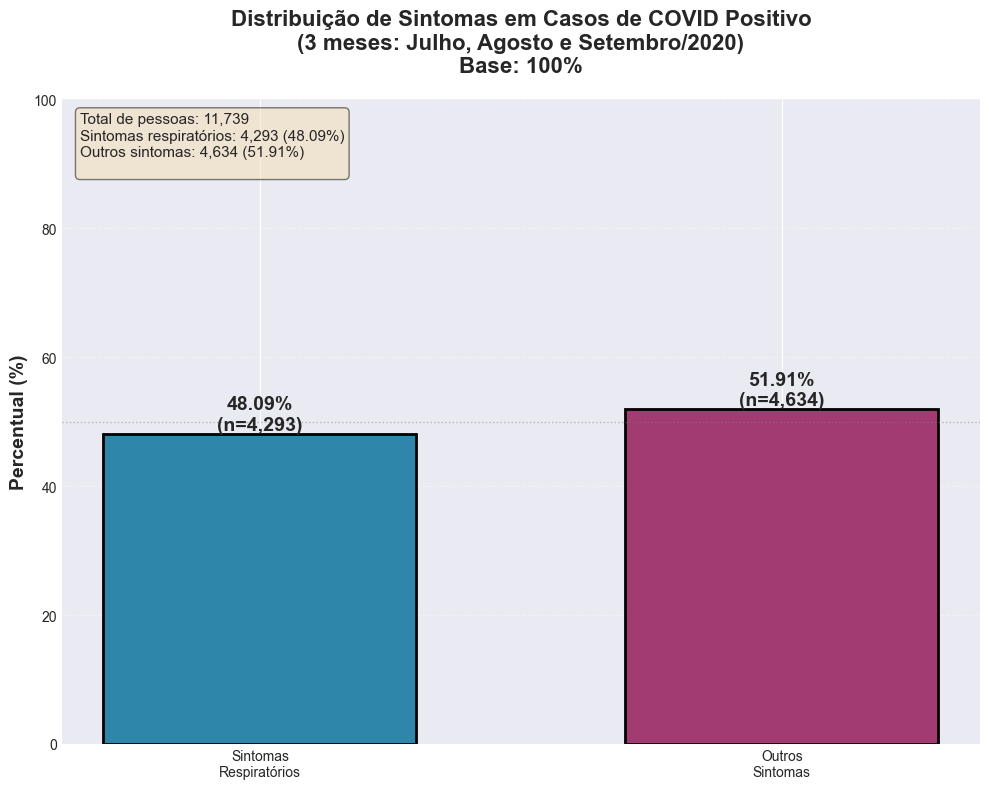

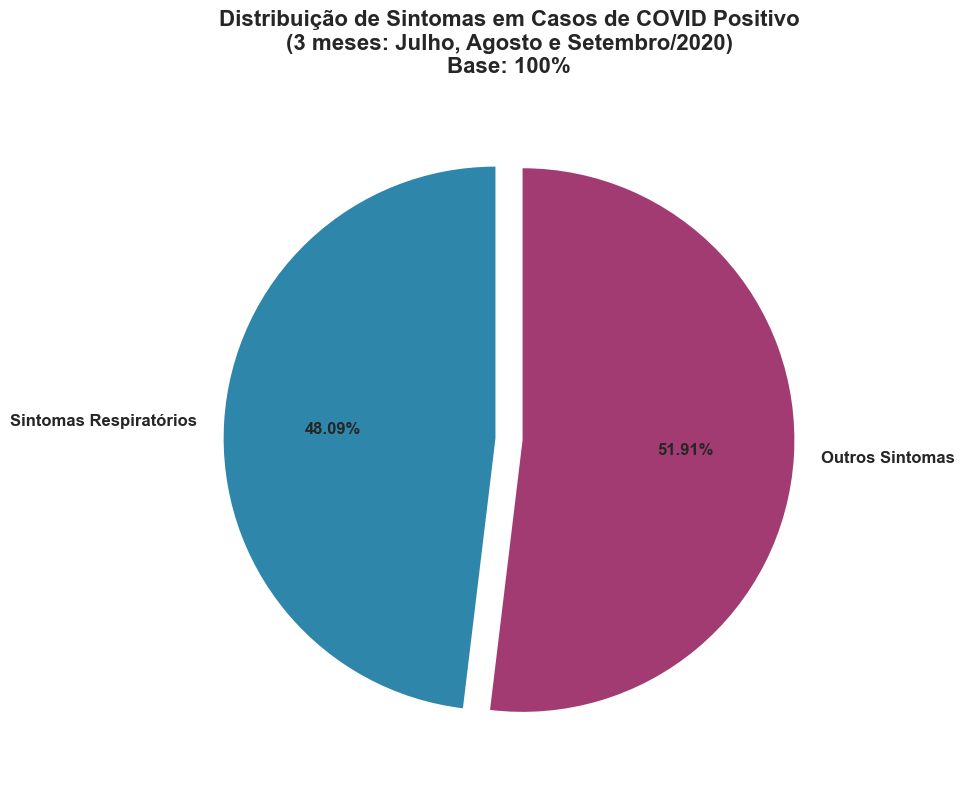


✓ Análise de sintomas concluída!


In [34]:
# Análise especial: Sintomas Respiratórios vs Outros Sintomas (base 100%)

if 'df_transformado_covid' in globals() and df_transformado_covid is not None:
    # Definir grupos de sintomas
    sintomas_respiratorios = ['B0012', 'B0013', 'B0018', 'B00111']  # tosse, dor garganta, coriza, perda cheiro/sabor
    sintomas_outros = ['B0011', 'B0014', 'B0015', 'B0016', 'B0017', 'B0019', 'B00110', 'B00112', 'B00113']
    
    # IDs únicos de pessoas (casos COVID) - SEM 'Mes' para contar pessoas únicas
    id_cols_pessoa = ['UF', 'CAPITAL', 'RM_RIDE', 'Estrato', 'UPA', 'posest']
    
    print(f"Total de linhas no DataFrame COVID: {len(df_transformado_covid):,}")
    
    # Filtrar apenas linhas de sintomas com Valor = 1 (Sim)
    df_sintomas = df_transformado_covid[
        df_transformado_covid['Variavel'].isin(sintomas_respiratorios + sintomas_outros) & 
        (df_transformado_covid['Valor'] == 1)
    ].copy()
    
    print(f"Linhas com sintomas = Sim: {len(df_sintomas):,}")
    
    # Criar uma chave única para cada pessoa (sem mês)
    df_sintomas['pessoa_id'] = df_sintomas[id_cols_pessoa].apply(tuple, axis=1)
    
    # Agrupar por pessoa e coletar todas as variáveis de sintomas de cada uma
    grupos = df_sintomas.groupby('pessoa_id')['Variavel'].apply(set).reset_index()
    
    # Verificar sintomas de forma vetorizada
    grupos['tem_respiratorio'] = grupos['Variavel'].apply(
        lambda x: bool(x & set(sintomas_respiratorios))
    )
    grupos['tem_outros'] = grupos['Variavel'].apply(
        lambda x: bool(x & set(sintomas_outros))
    )
    
    # Contar pessoas
    pessoas_com_respiratorio = set(grupos[grupos['tem_respiratorio']]['pessoa_id'].values)
    pessoas_com_outros = set(grupos[grupos['tem_outros']]['pessoa_id'].values)
    
    # Calcular total de pessoas únicas (sem mês)
    pessoas_unicas = df_transformado_covid[id_cols_pessoa].drop_duplicates()
    total_geral = len(pessoas_unicas)
    
    total_respiratorio = len(pessoas_com_respiratorio)
    total_outros = len(pessoas_com_outros)
    
    print(f"\nTotal de pessoas com COVID positivo (3 meses): {total_geral:,}")
    
    soma_categorias = total_respiratorio + total_outros
    if soma_categorias > 0:
        pct_respiratorio = (total_respiratorio / soma_categorias * 100)
        pct_outros = (total_outros / soma_categorias * 100)
    else:
        pct_respiratorio = 0
        pct_outros = 0
    
    print(f"\nPessoas com pelo menos 1 sintoma respiratório: {total_respiratorio:,} ({pct_respiratorio:.2f}%)")
    print(f"Pessoas com pelo menos 1 outro sintoma: {total_outros:,} ({pct_outros:.2f}%)")
    print(f"Total de pessoas: {total_geral:,}")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    categorias = ['Sintomas\nRespiratórios', 'Outros\nSintomas']
    valores = [pct_respiratorio, pct_outros]
    cores = ['#2E86AB', '#A23B72']  # Azul para respiratórios, rosa para outros
    
    # Gráfico de barras (base 100% = total_geral)
    bars = ax.bar(categorias, valores, color=cores, width=0.6, edgecolor='black', linewidth=2)
    
    # Adicionar valores nas barras
    for bar, valor, qtd in zip(bars, valores, [total_respiratorio, total_outros]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height,
                f'{valor:.2f}%\n(n={qtd:,})', ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    ax.set_ylabel('Percentual (%)', fontsize=14, fontweight='bold')
    ax.set_title('Distribuição de Sintomas em Casos de COVID Positivo\n(3 meses: Julho, Agosto e Setembro/2020)\nBase: 100%', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Adicionar linha de referência em 50%
    ax.axhline(y=50, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    
    # Adicionar informações adicionais
    info_text = f"""Total de pessoas: {total_geral:,}
Sintomas respiratórios: {total_respiratorio:,} ({pct_respiratorio:.2f}%)
Outros sintomas: {total_outros:,} ({pct_outros:.2f}%)
"""
    
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sizes = [pct_respiratorio, pct_outros]
    labels = ['Sintomas Respiratórios', 'Outros Sintomas']
    cores_pizza = ['#2E86AB', '#A23B72']  # Azul, rosa
    explode = (0.05, 0.05)
    
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.2f%%',
                                      colors=cores_pizza, explode=explode,
                                      startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
    
    ax.set_title('Distribuição de Sintomas em Casos de COVID Positivo\n(3 meses: Julho, Agosto e Setembro/2020)\nBase: 100%',
                 fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Análise de sintomas concluída!")
else:
    print('Erro: df_transformado_covid não está disponível.')


Gerando gráficos para 21 itens com dados disponíveis (apenas casos COVID, 3 meses)...


################################################################################
Item 1/21: A005
################################################################################


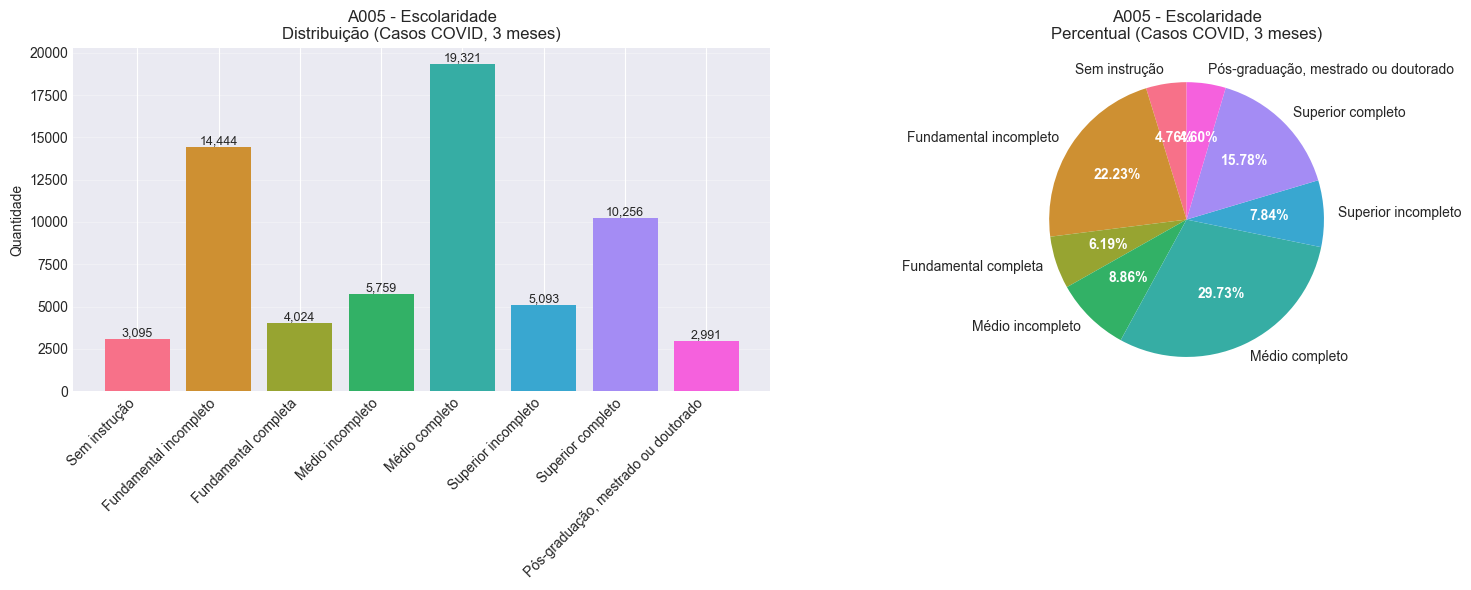

                               Label  Quantidade  Percentual
                       Sem instrução        3095        4.76
              Fundamental incompleto       14444       22.23
                Fundamental completa        4024        6.19
                    Médio incompleto        5759        8.86
                      Médio completo       19321       29.73
                 Superior incompleto        5093        7.84
                   Superior completo       10256       15.78
Pós-graduação, mestrado ou doutorado        2991        4.60

################################################################################
Item 2/21: B011
################################################################################


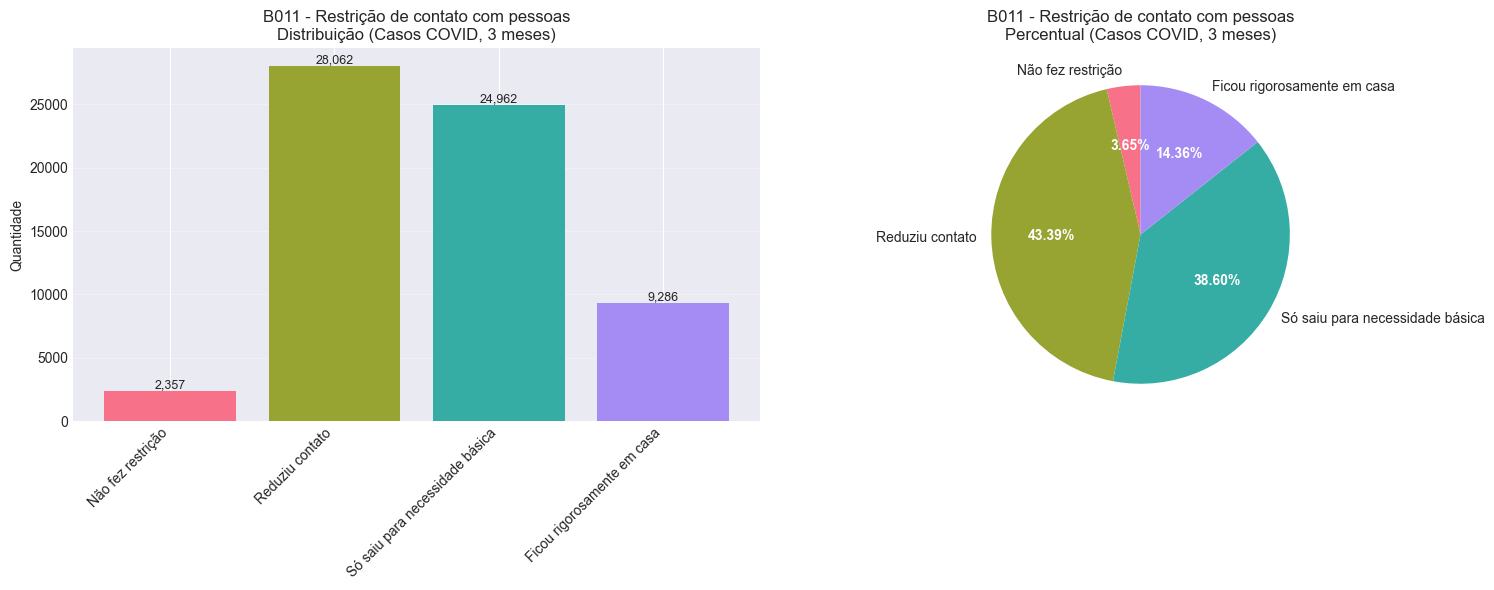

                          Label  Quantidade  Percentual
              Não fez restrição        2357        3.63
                Reduziu contato       28062       43.18
Só saiu para necessidade básica       24962       38.41
    Ficou rigorosamente em casa        9286       14.29

################################################################################
Item 3/21: C001
################################################################################


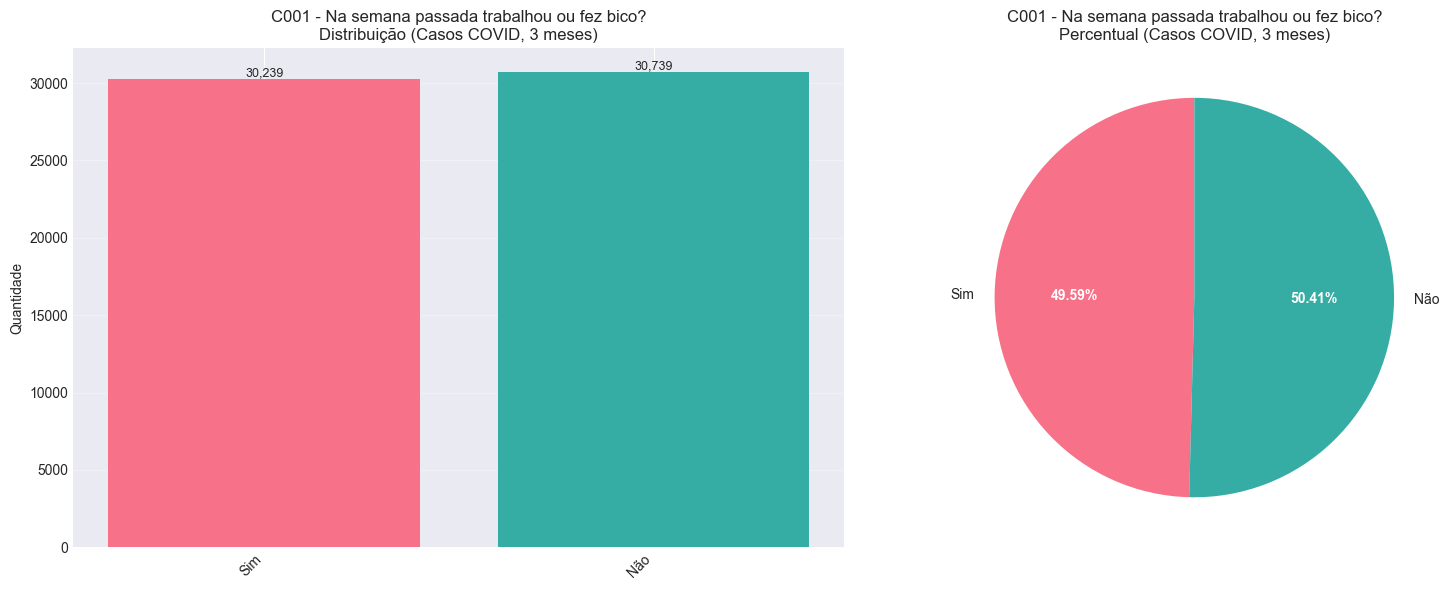

Label  Quantidade  Percentual
  Sim       30239       49.59
  Não       30739       50.41

################################################################################
Item 4/21: C01012
################################################################################


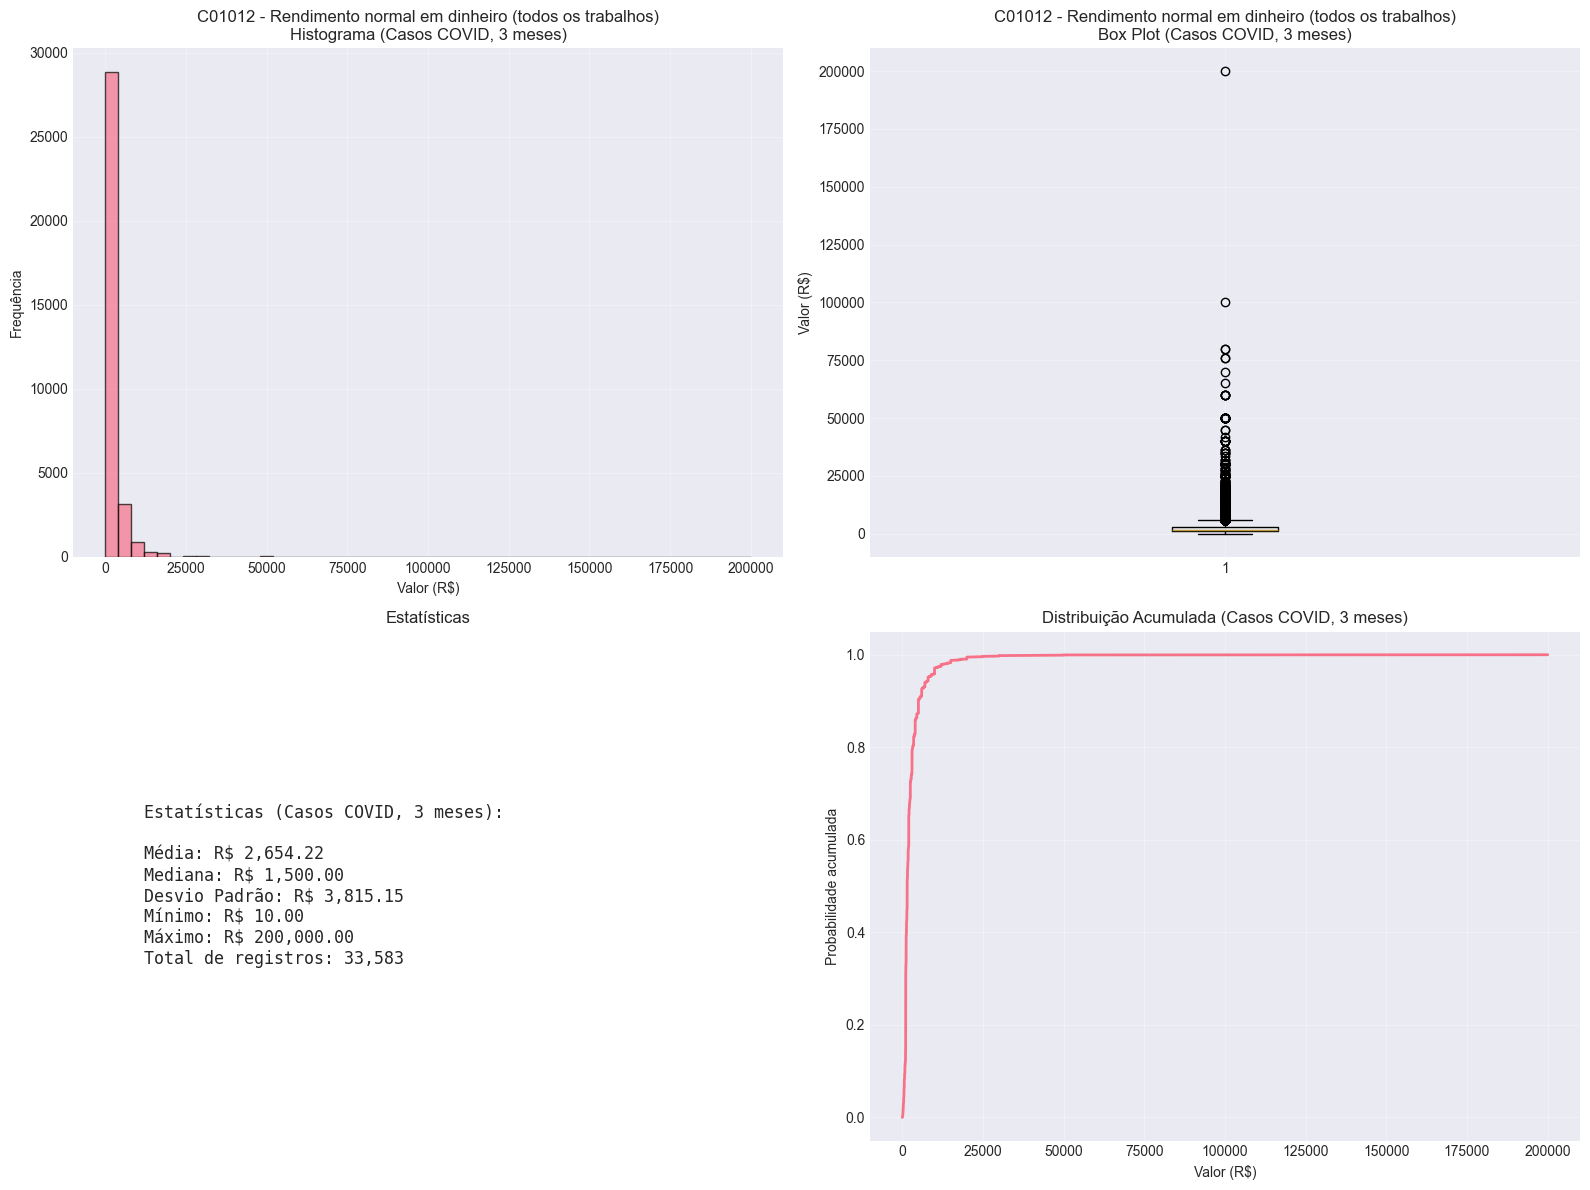

Estatísticas (Casos COVID, 3 meses):

Média: R$ 2,654.22
Mediana: R$ 1,500.00
Desvio Padrão: R$ 3,815.15
Mínimo: R$ 10.00
Máximo: R$ 200,000.00
Total de registros: 33,583

################################################################################
Item 5/21: C01022
################################################################################


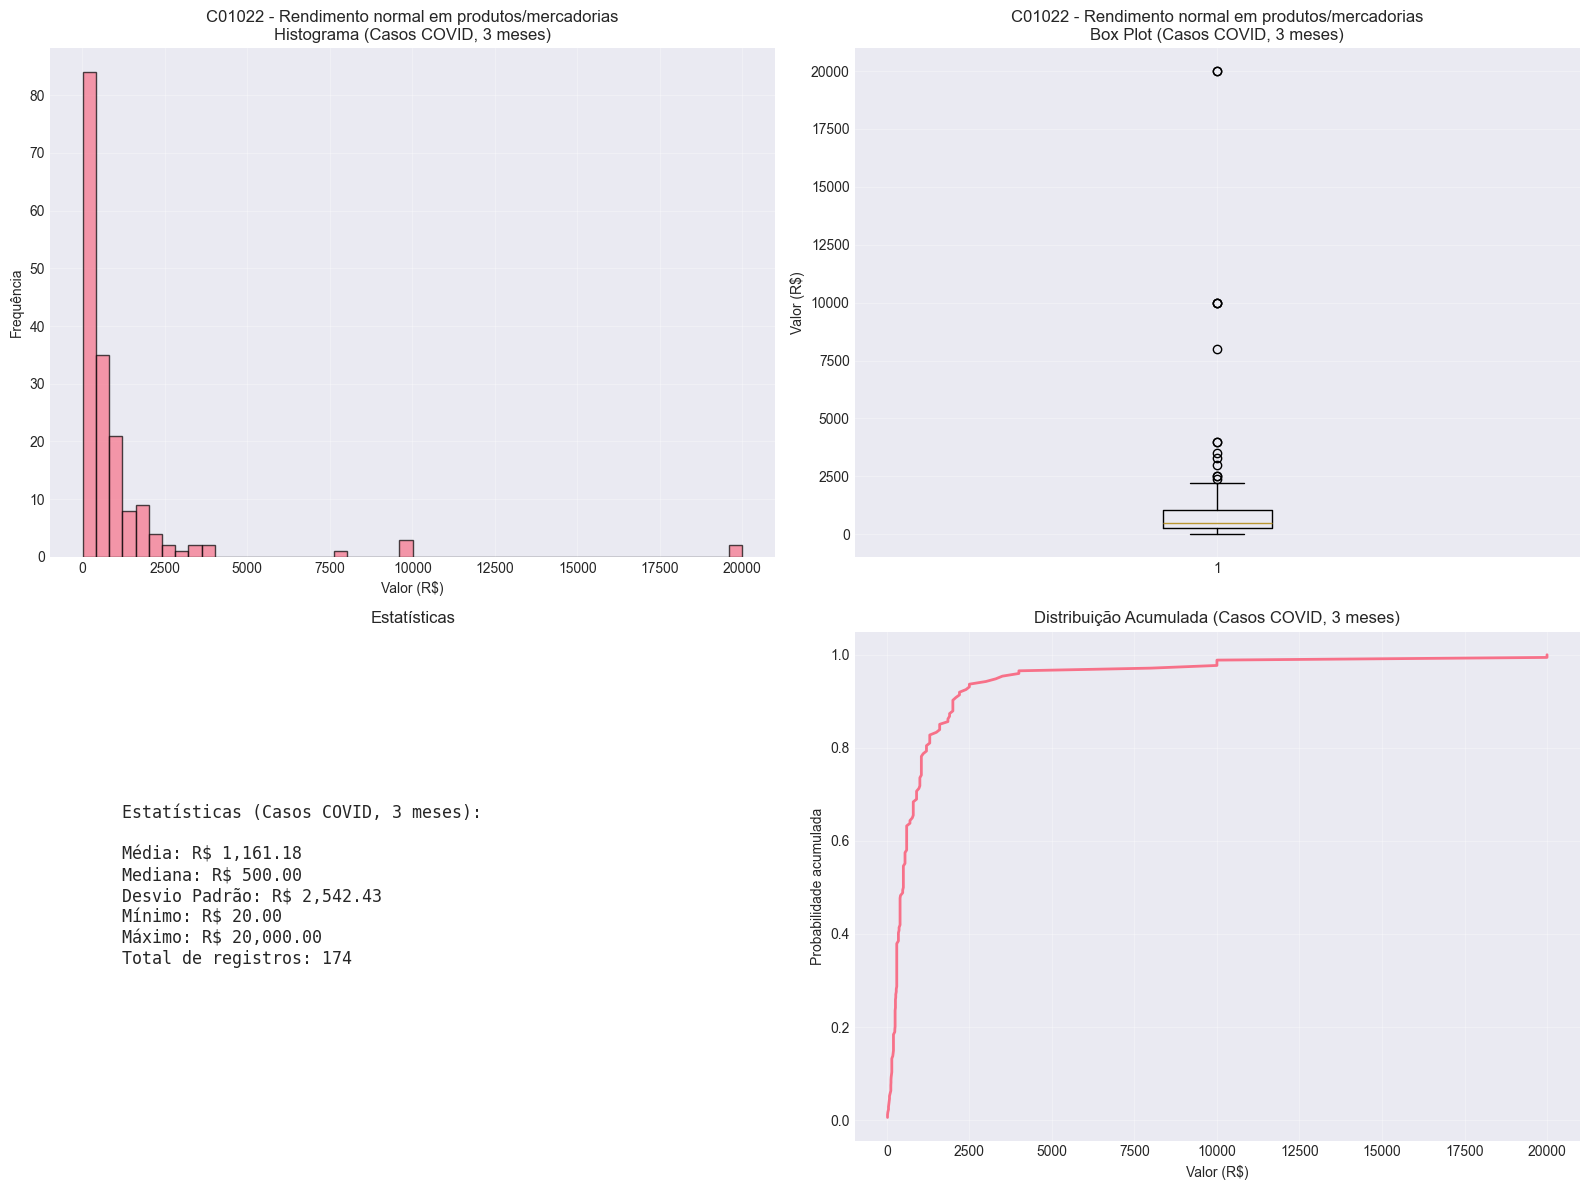

Estatísticas (Casos COVID, 3 meses):

Média: R$ 1,161.18
Mediana: R$ 500.00
Desvio Padrão: R$ 2,542.43
Mínimo: R$ 20.00
Máximo: R$ 20,000.00
Total de registros: 174

################################################################################
Item 6/21: C011A12
################################################################################


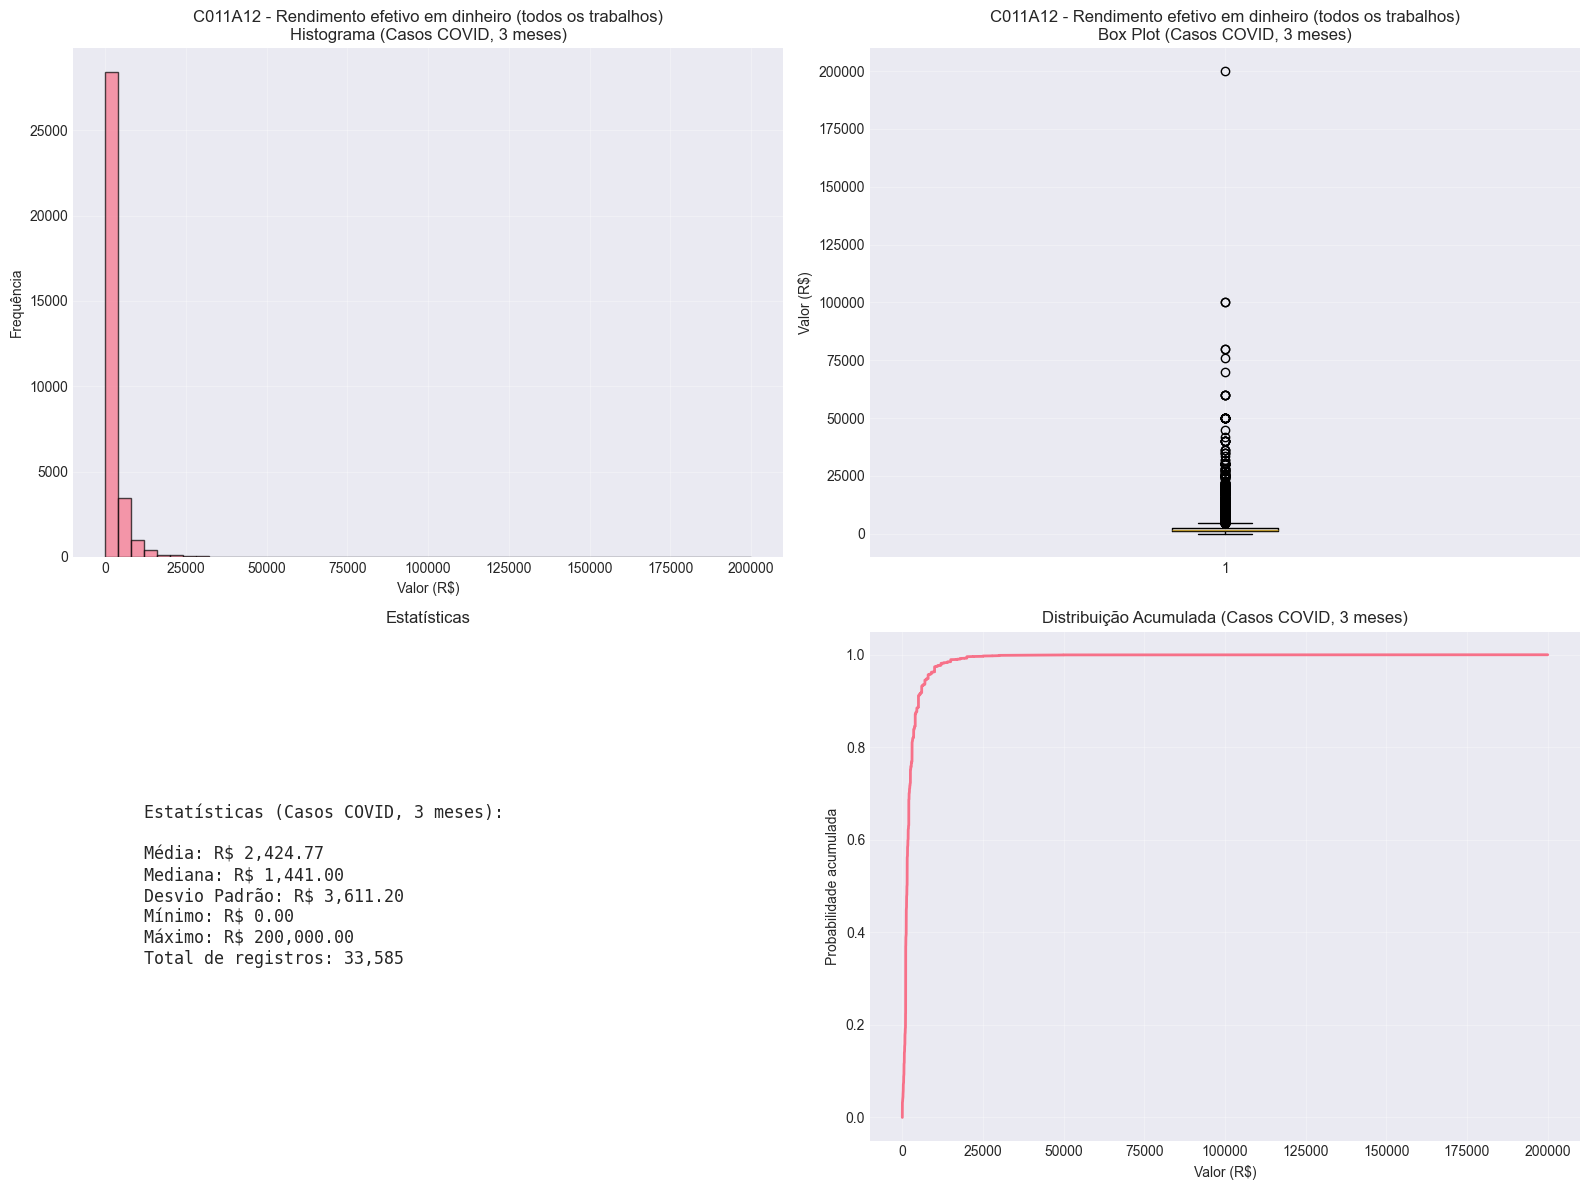

Estatísticas (Casos COVID, 3 meses):

Média: R$ 2,424.77
Mediana: R$ 1,441.00
Desvio Padrão: R$ 3,611.20
Mínimo: R$ 0.00
Máximo: R$ 200,000.00
Total de registros: 33,585

################################################################################
Item 7/21: C011A22
################################################################################


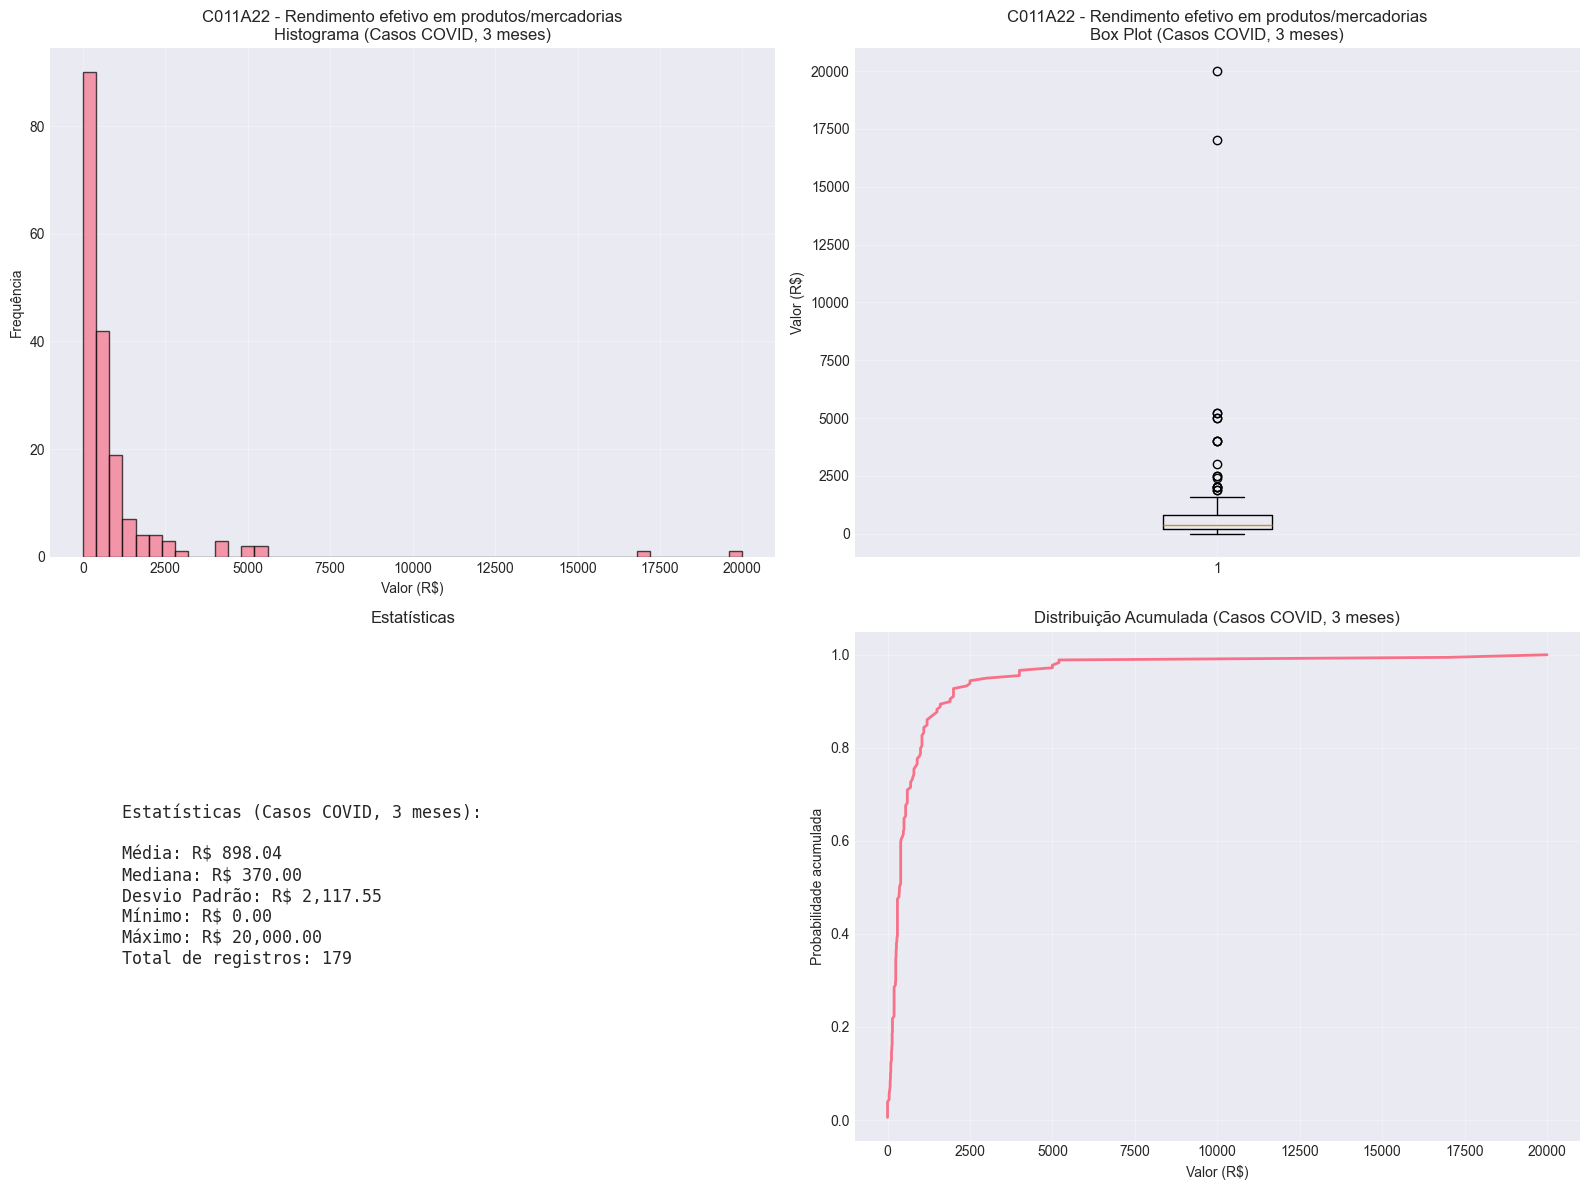

Estatísticas (Casos COVID, 3 meses):

Média: R$ 898.04
Mediana: R$ 370.00
Desvio Padrão: R$ 2,117.55
Mínimo: R$ 0.00
Máximo: R$ 20,000.00
Total de registros: 179

################################################################################
Item 8/21: C012
################################################################################


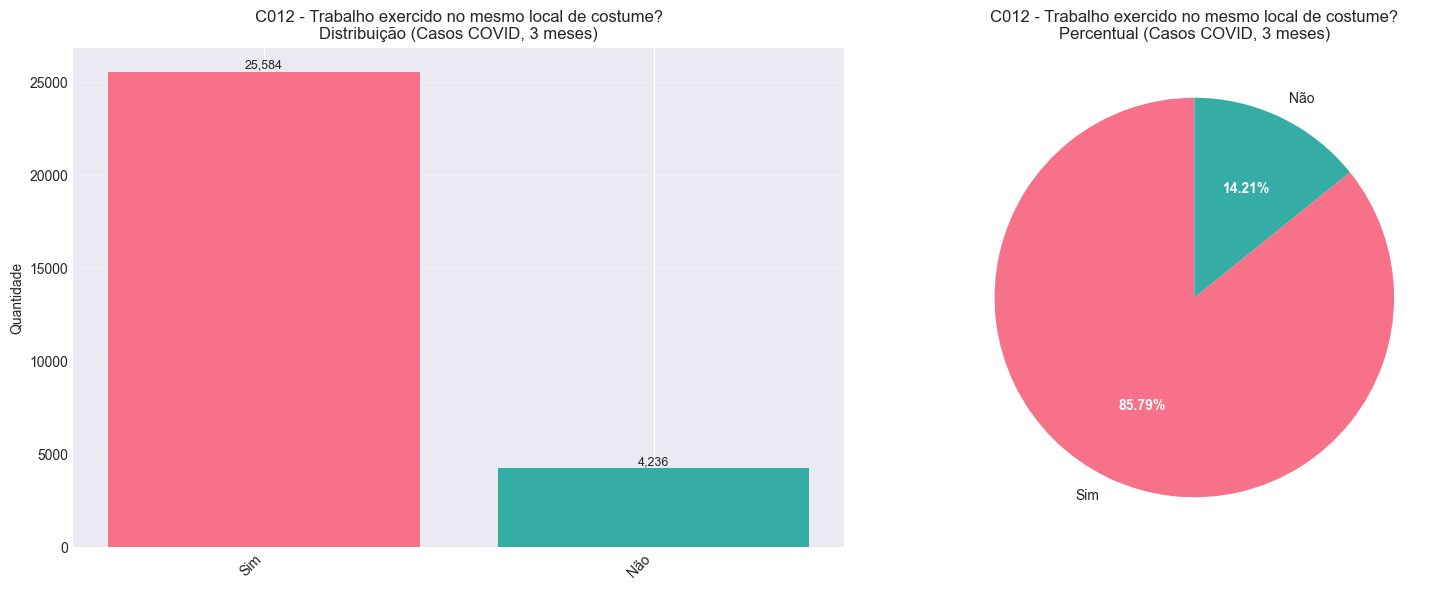

Label  Quantidade  Percentual
  Sim       25584       85.79
  Não        4236       14.21

################################################################################
Item 9/21: C013
################################################################################


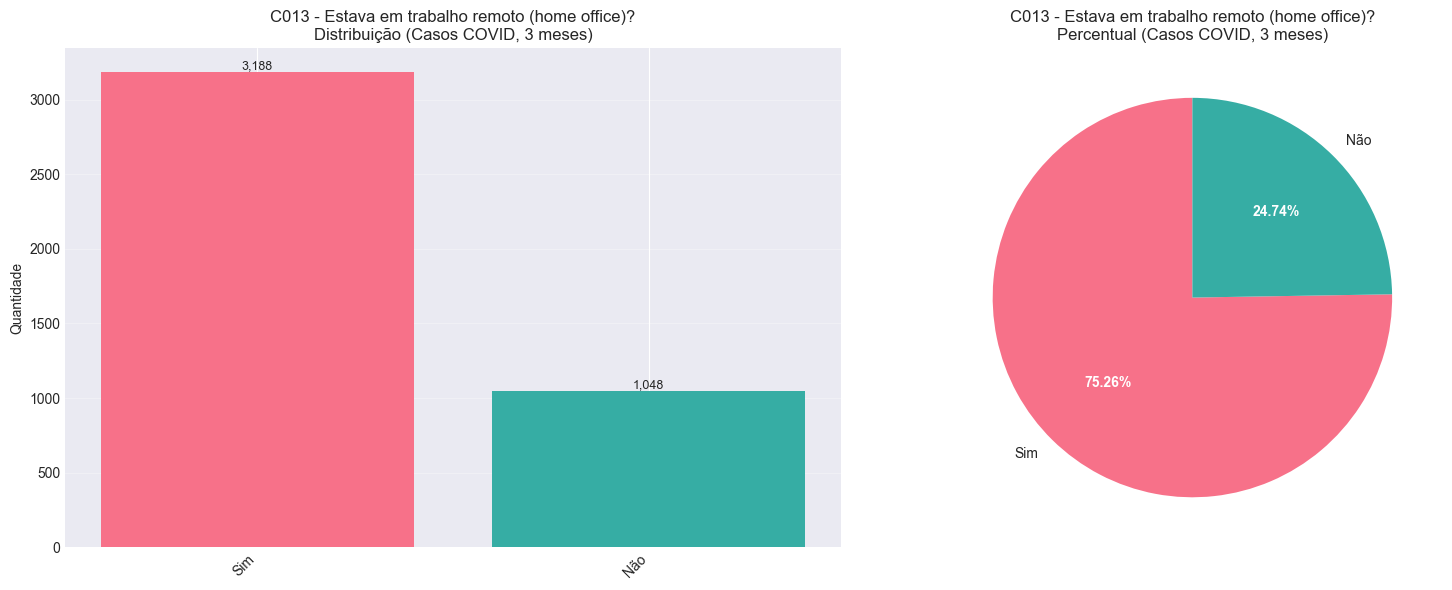

Label  Quantidade  Percentual
  Sim        3188       75.26
  Não        1048       24.74

################################################################################
Item 10/21: D0013
################################################################################


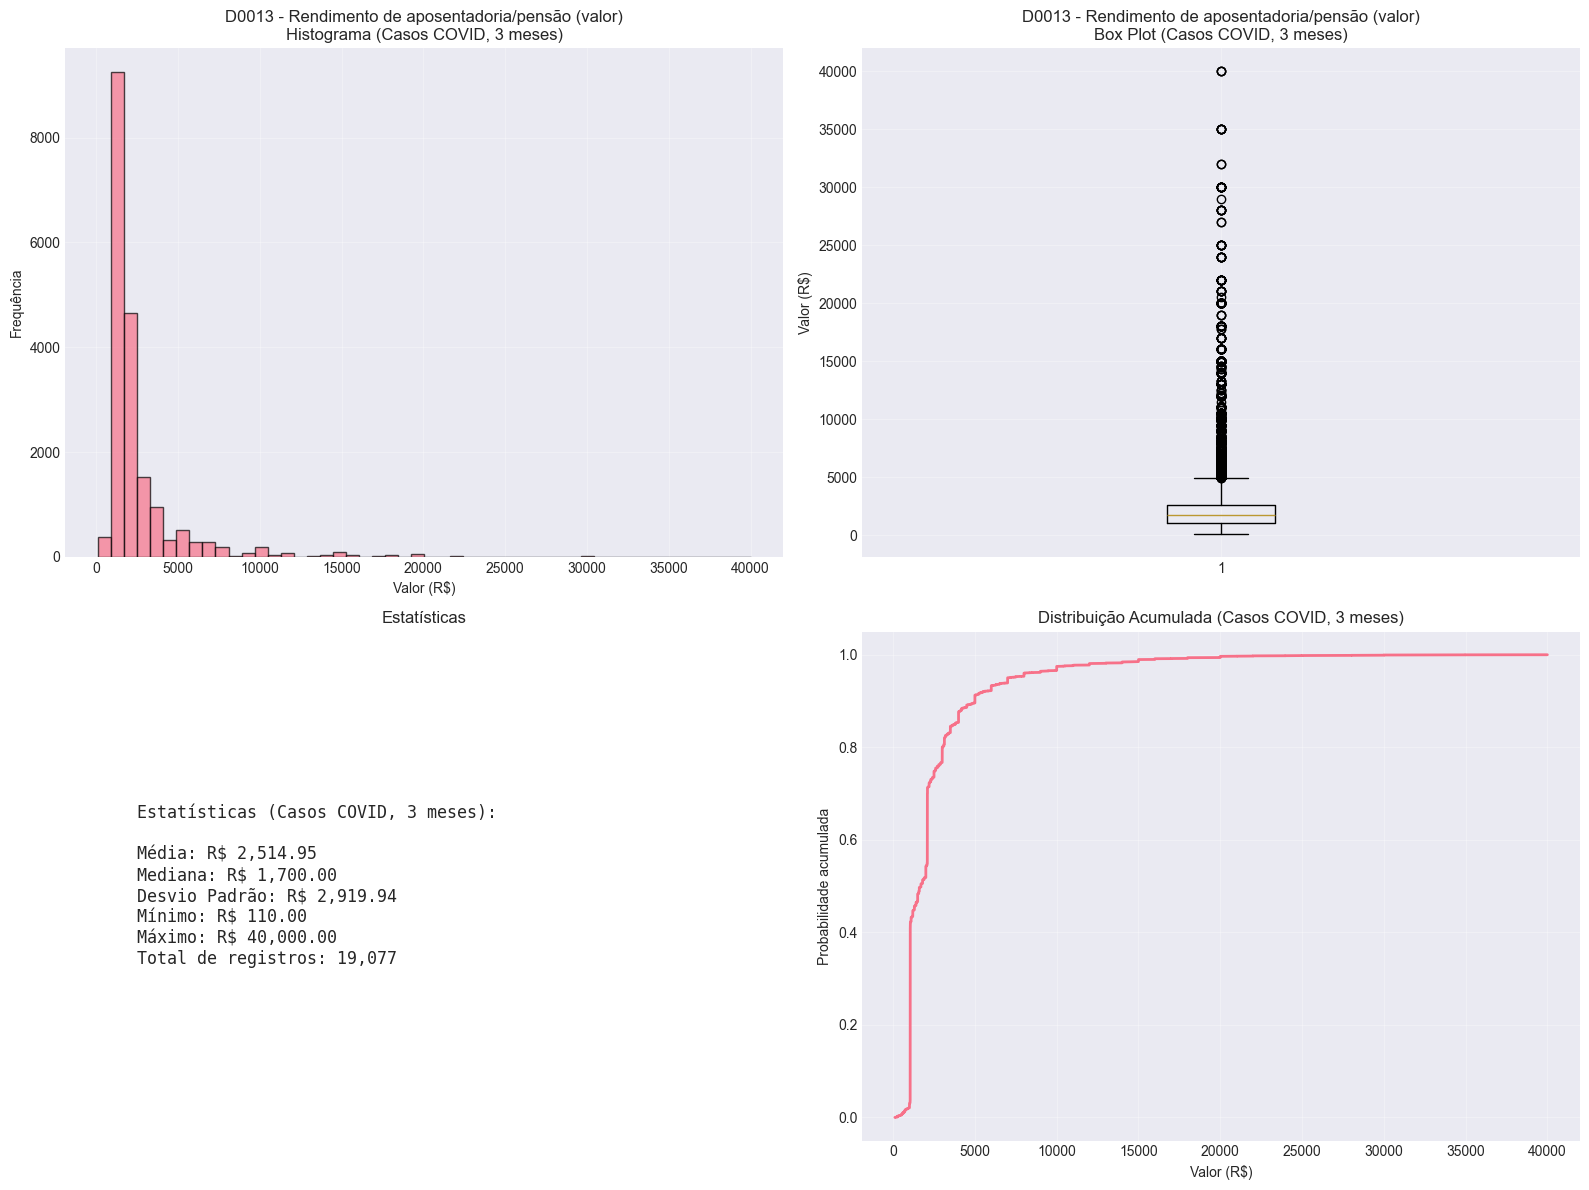

Estatísticas (Casos COVID, 3 meses):

Média: R$ 2,514.95
Mediana: R$ 1,700.00
Desvio Padrão: R$ 2,919.94
Mínimo: R$ 110.00
Máximo: R$ 40,000.00
Total de registros: 19,077

################################################################################
Item 11/21: D0023
################################################################################


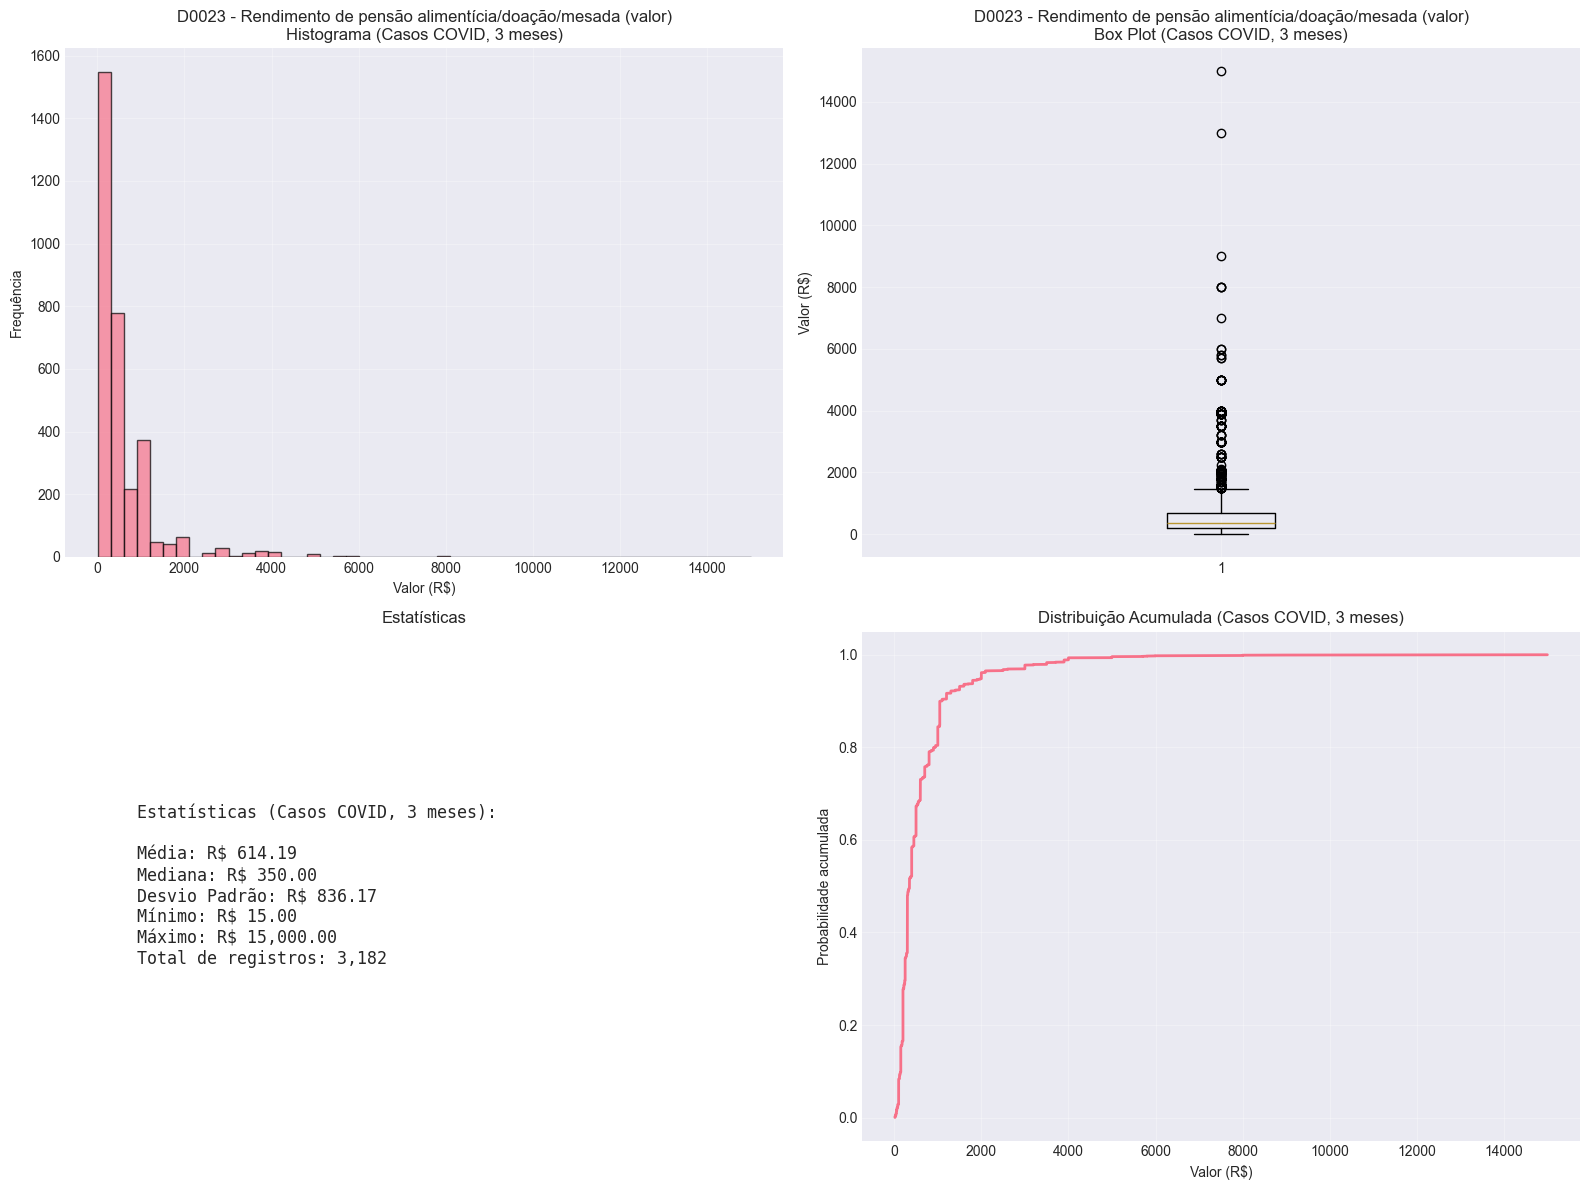

Estatísticas (Casos COVID, 3 meses):

Média: R$ 614.19
Mediana: R$ 350.00
Desvio Padrão: R$ 836.17
Mínimo: R$ 15.00
Máximo: R$ 15,000.00
Total de registros: 3,182

################################################################################
Item 12/21: D0033
################################################################################


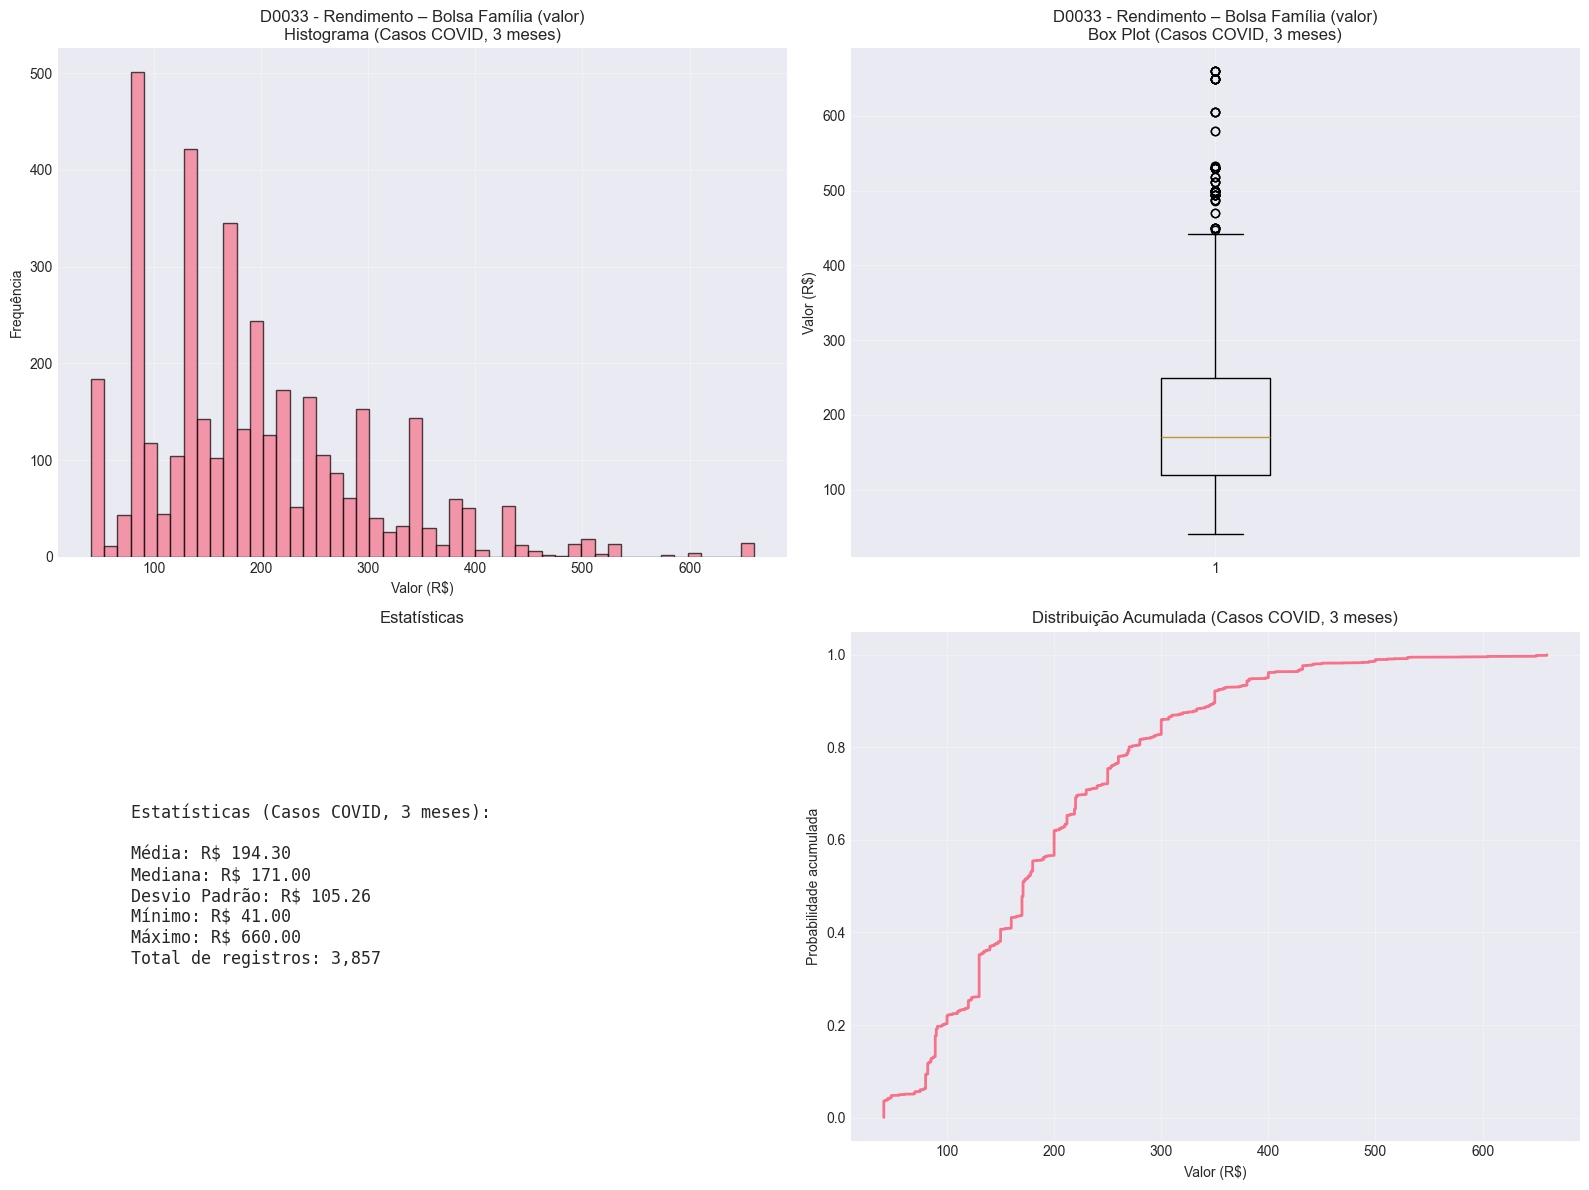

Estatísticas (Casos COVID, 3 meses):

Média: R$ 194.30
Mediana: R$ 171.00
Desvio Padrão: R$ 105.26
Mínimo: R$ 41.00
Máximo: R$ 660.00
Total de registros: 3,857

################################################################################
Item 13/21: D0043
################################################################################


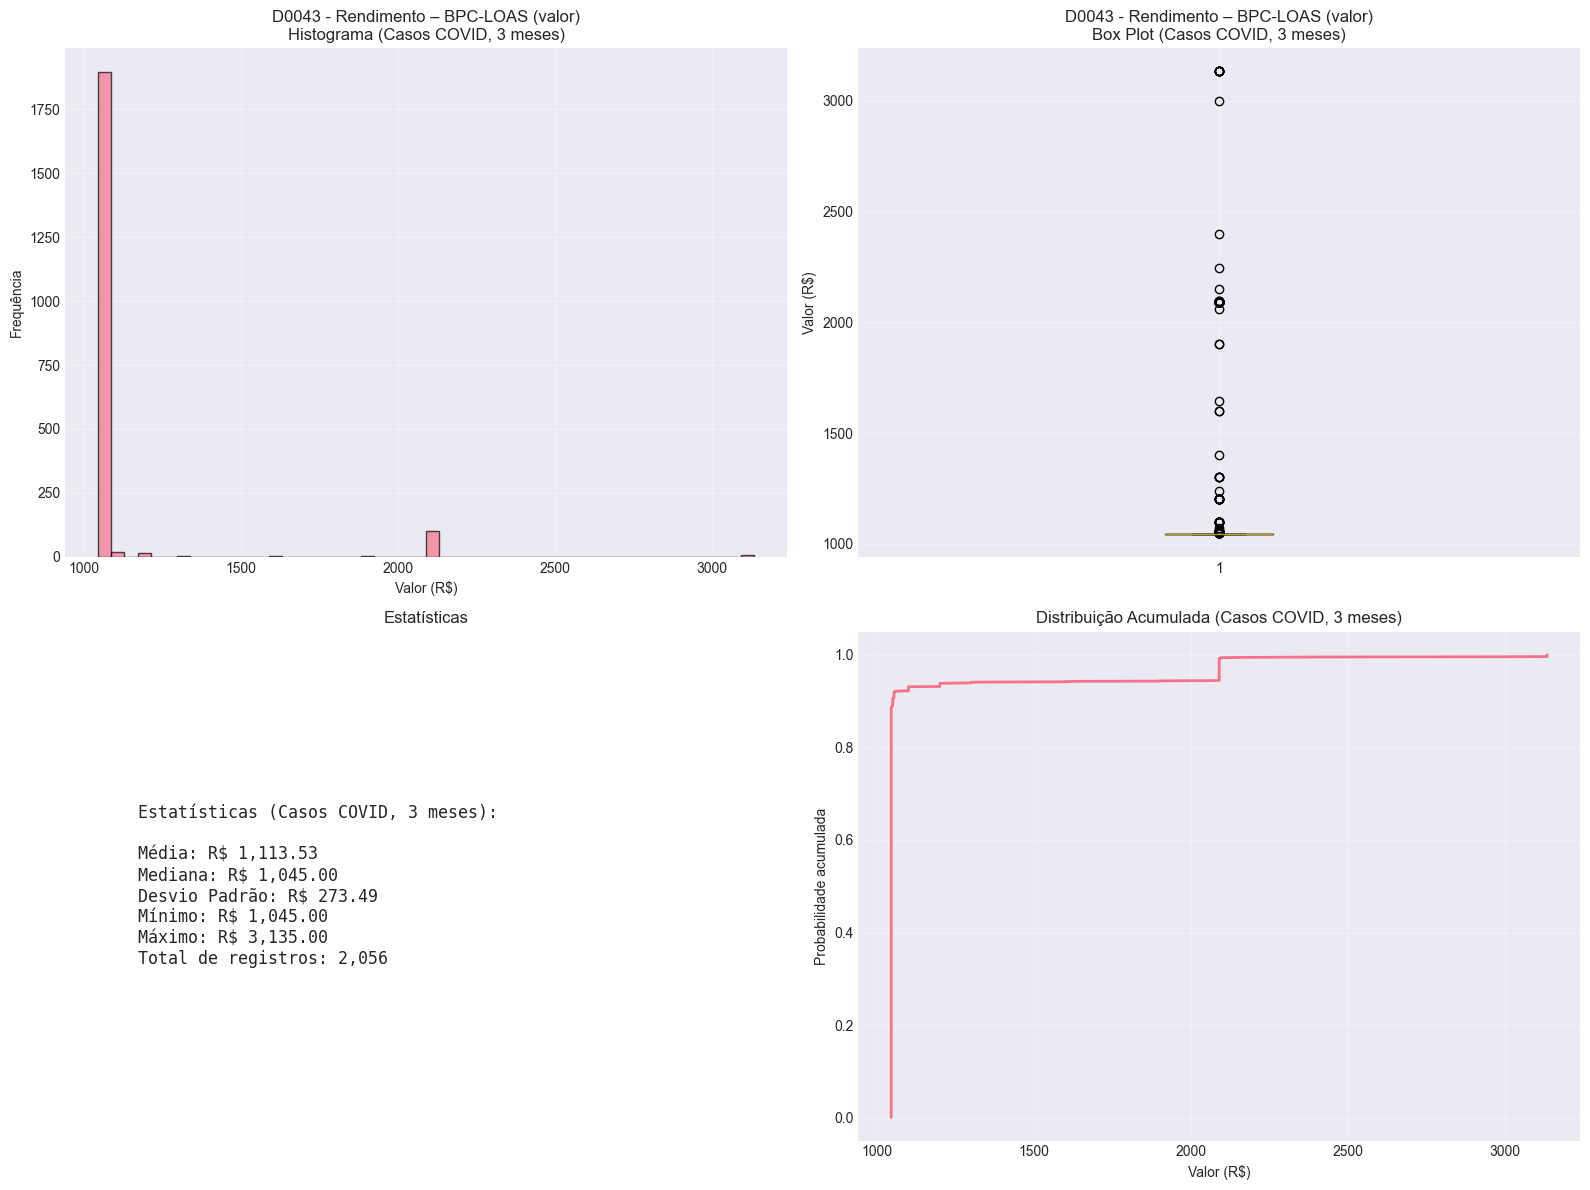

Estatísticas (Casos COVID, 3 meses):

Média: R$ 1,113.53
Mediana: R$ 1,045.00
Desvio Padrão: R$ 273.49
Mínimo: R$ 1,045.00
Máximo: R$ 3,135.00
Total de registros: 2,056

################################################################################
Item 14/21: D0053
################################################################################


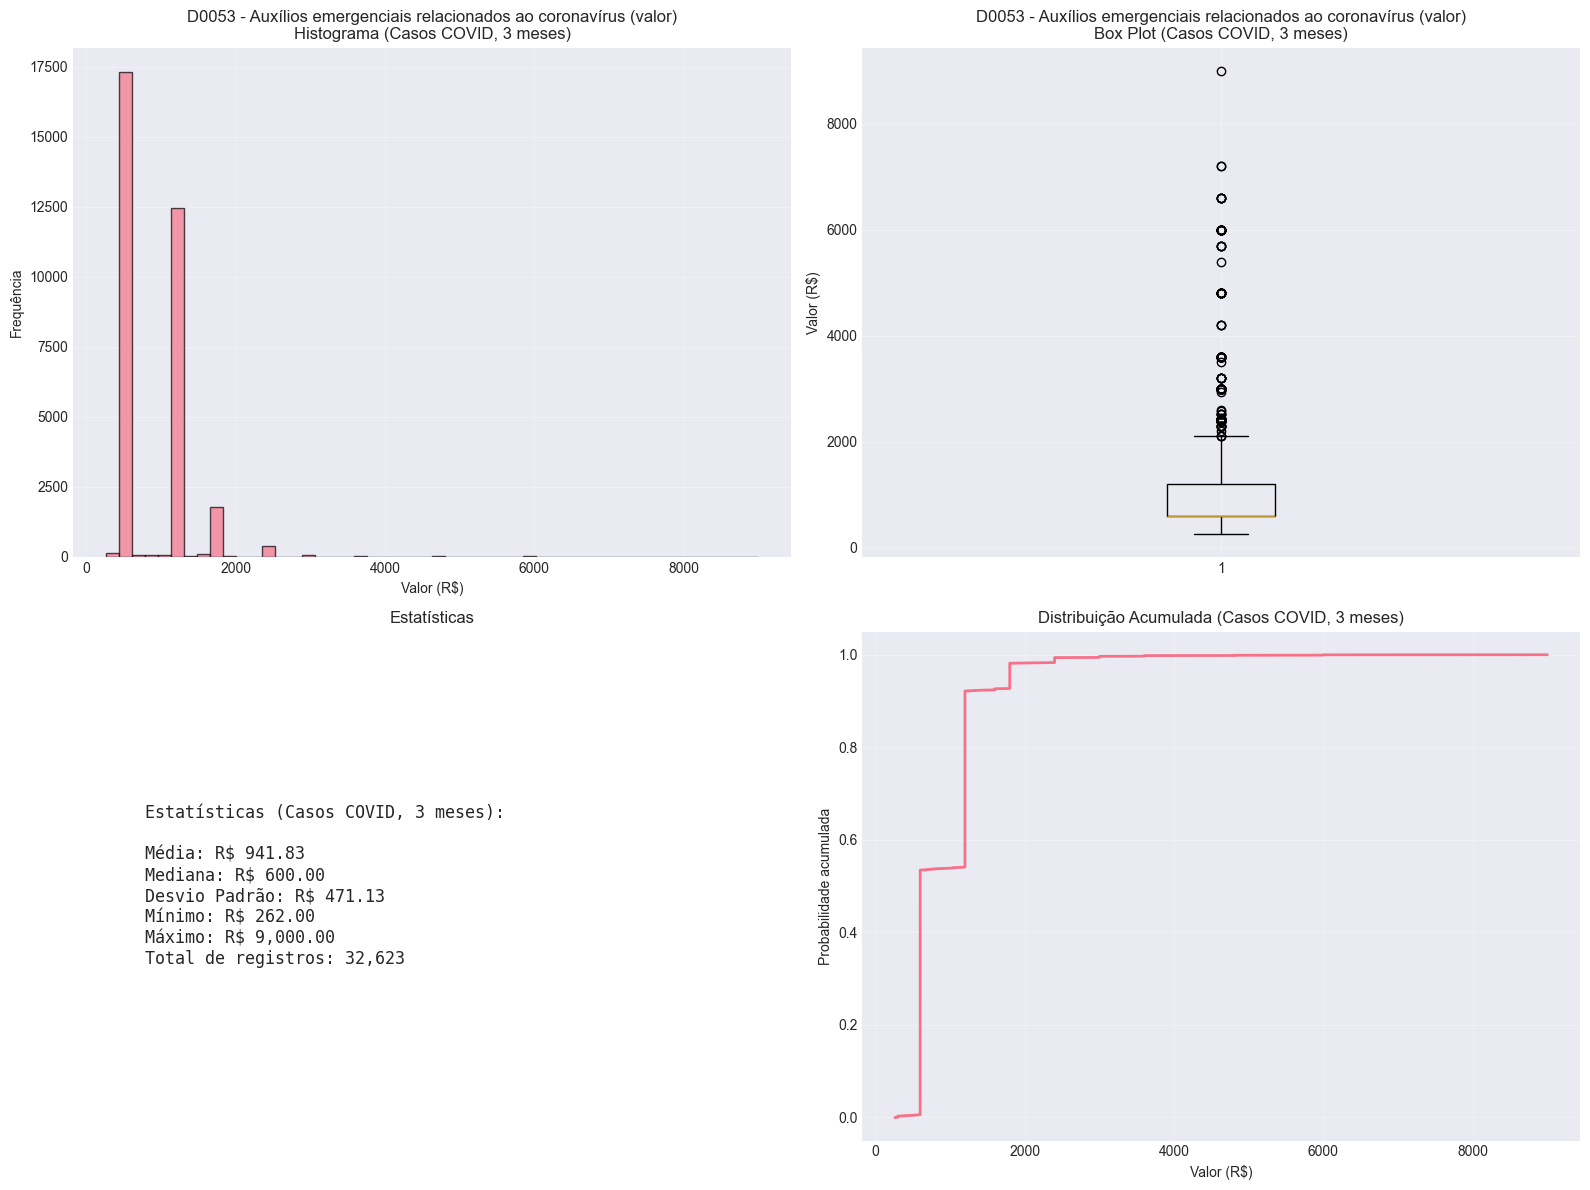

Estatísticas (Casos COVID, 3 meses):

Média: R$ 941.83
Mediana: R$ 600.00
Desvio Padrão: R$ 471.13
Mínimo: R$ 262.00
Máximo: R$ 9,000.00
Total de registros: 32,623

################################################################################
Item 15/21: D0063
################################################################################


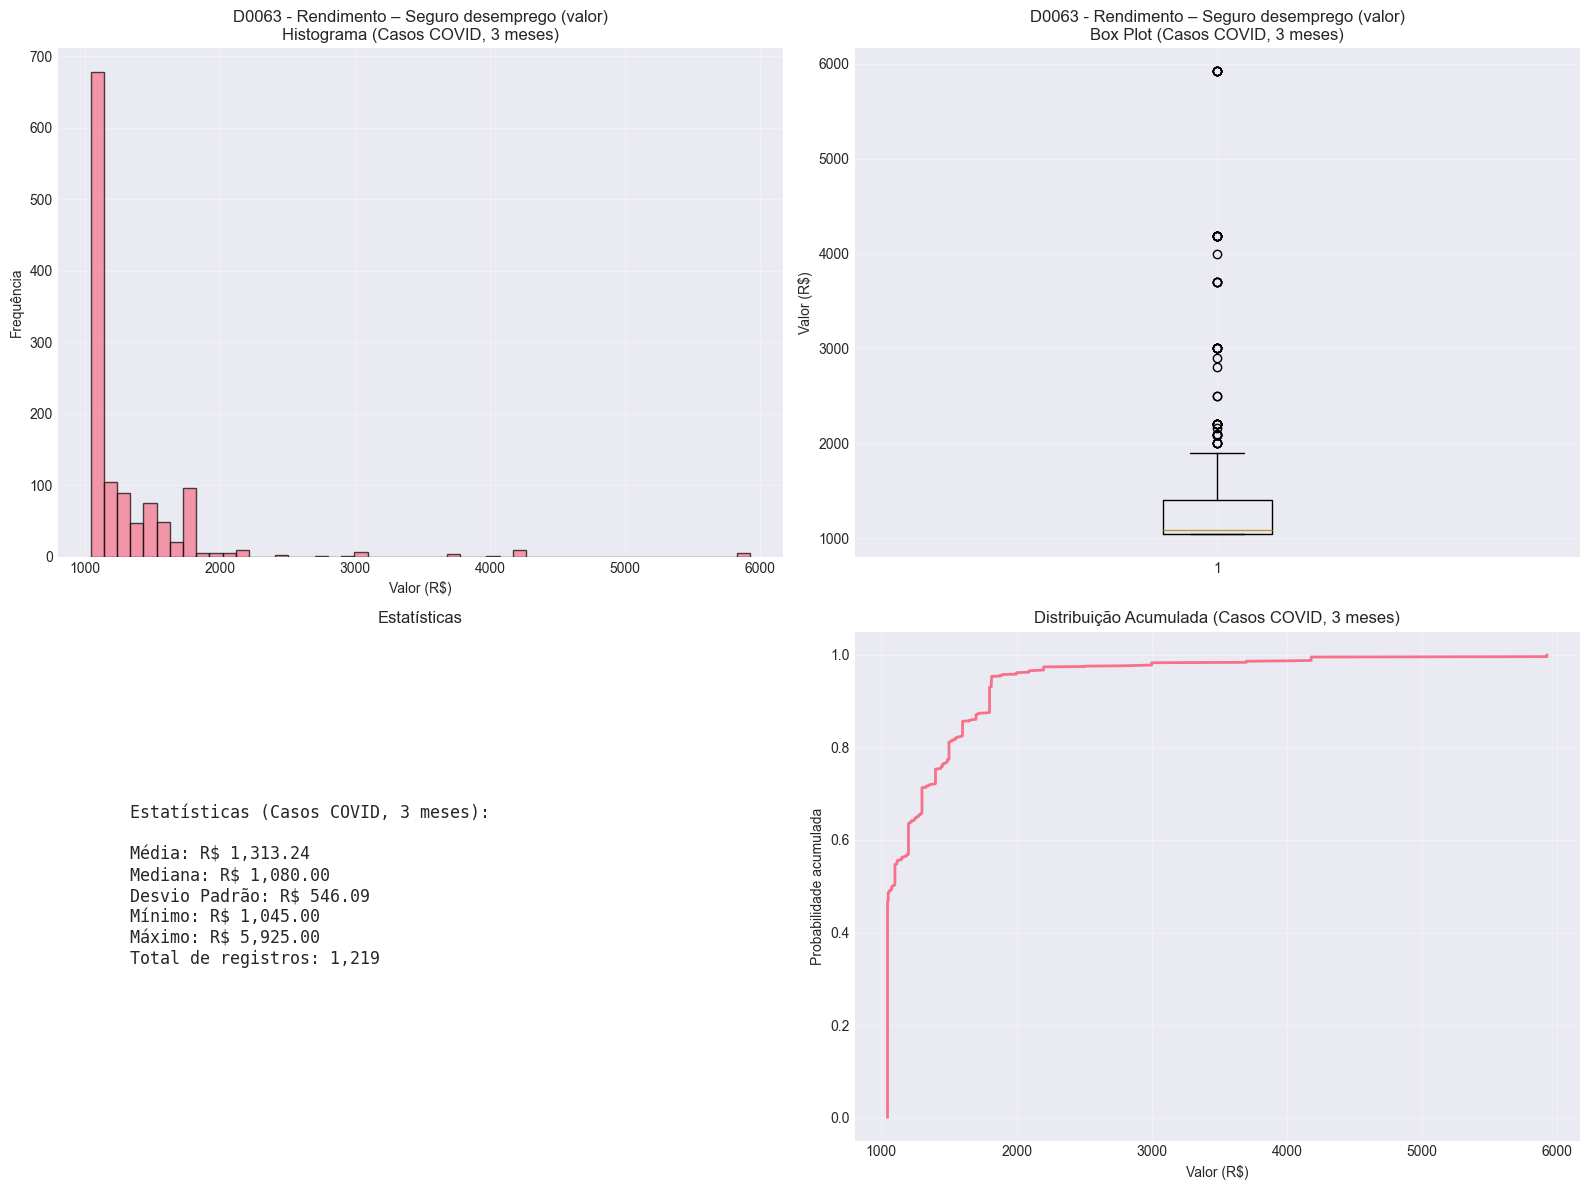

Estatísticas (Casos COVID, 3 meses):

Média: R$ 1,313.24
Mediana: R$ 1,080.00
Desvio Padrão: R$ 546.09
Mínimo: R$ 1,045.00
Máximo: R$ 5,925.00
Total de registros: 1,219

################################################################################
Item 16/21: F001
################################################################################


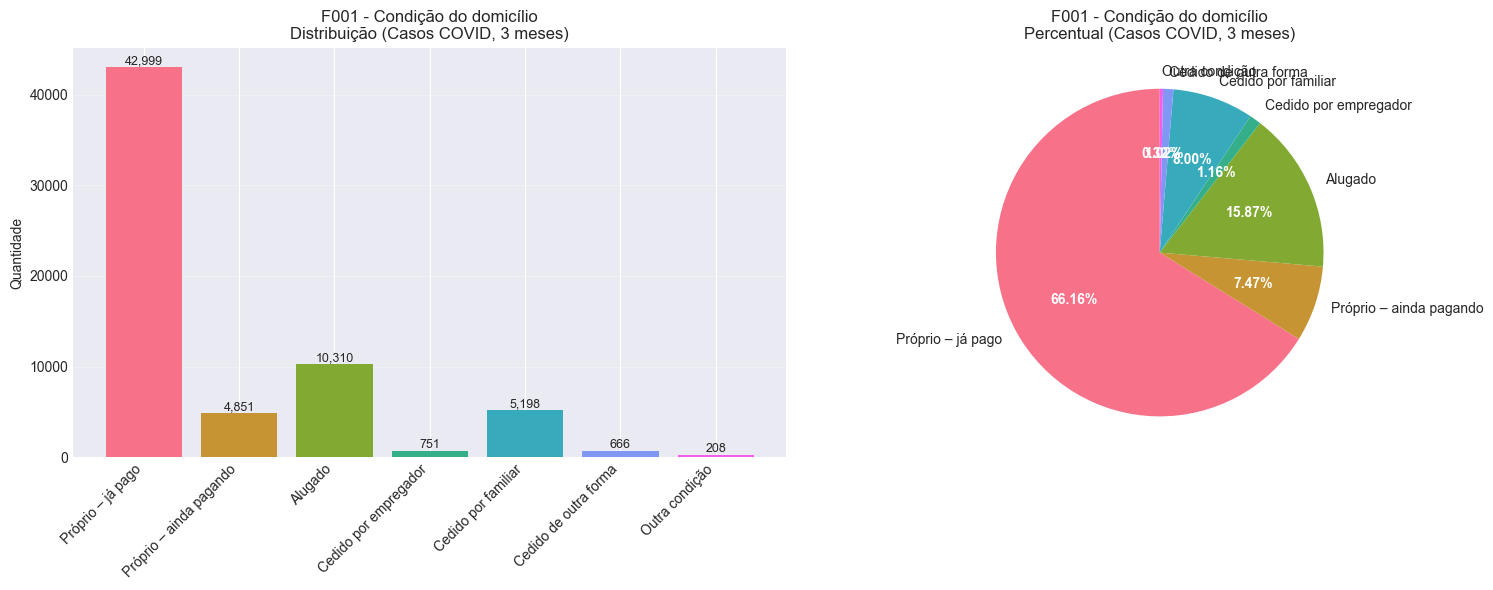

                  Label  Quantidade  Percentual
      Próprio – já pago       42999       66.17
Próprio – ainda pagando        4851        7.47
                Alugado       10310       15.87
  Cedido por empregador         751        1.16
    Cedido por familiar        5198        8.00
  Cedido de outra forma         666        1.02
         Outra condição         208        0.32

################################################################################
Item 17/21: F002A1
################################################################################


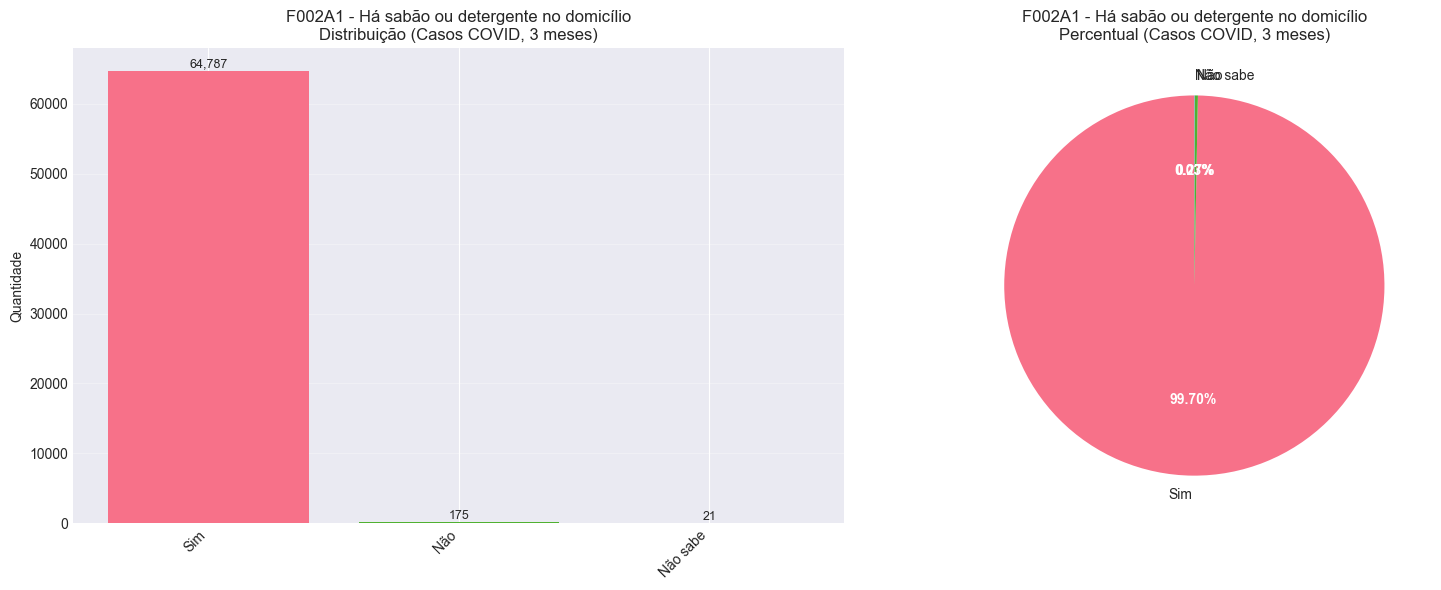

   Label  Quantidade  Percentual
     Sim       64787       99.70
     Não         175        0.27
Não sabe          21        0.03

################################################################################
Item 18/21: F002A2
################################################################################


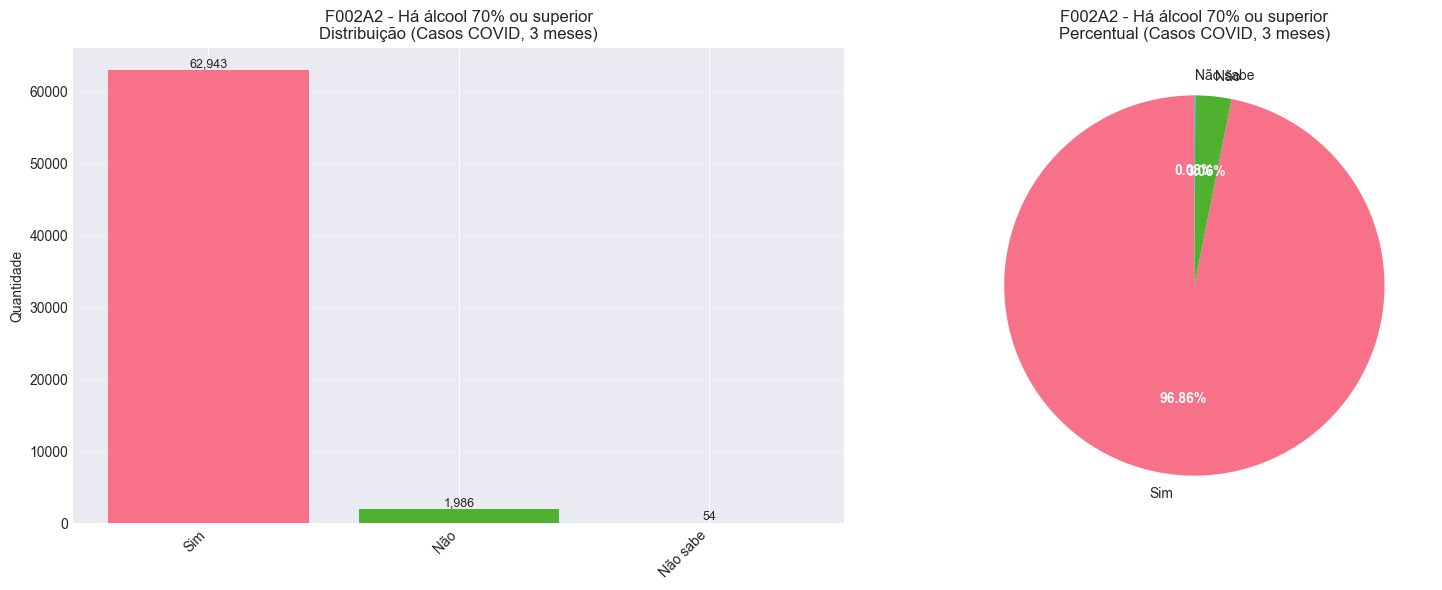

   Label  Quantidade  Percentual
     Sim       62943       96.86
     Não        1986        3.06
Não sabe          54        0.08

################################################################################
Item 19/21: F002A3
################################################################################


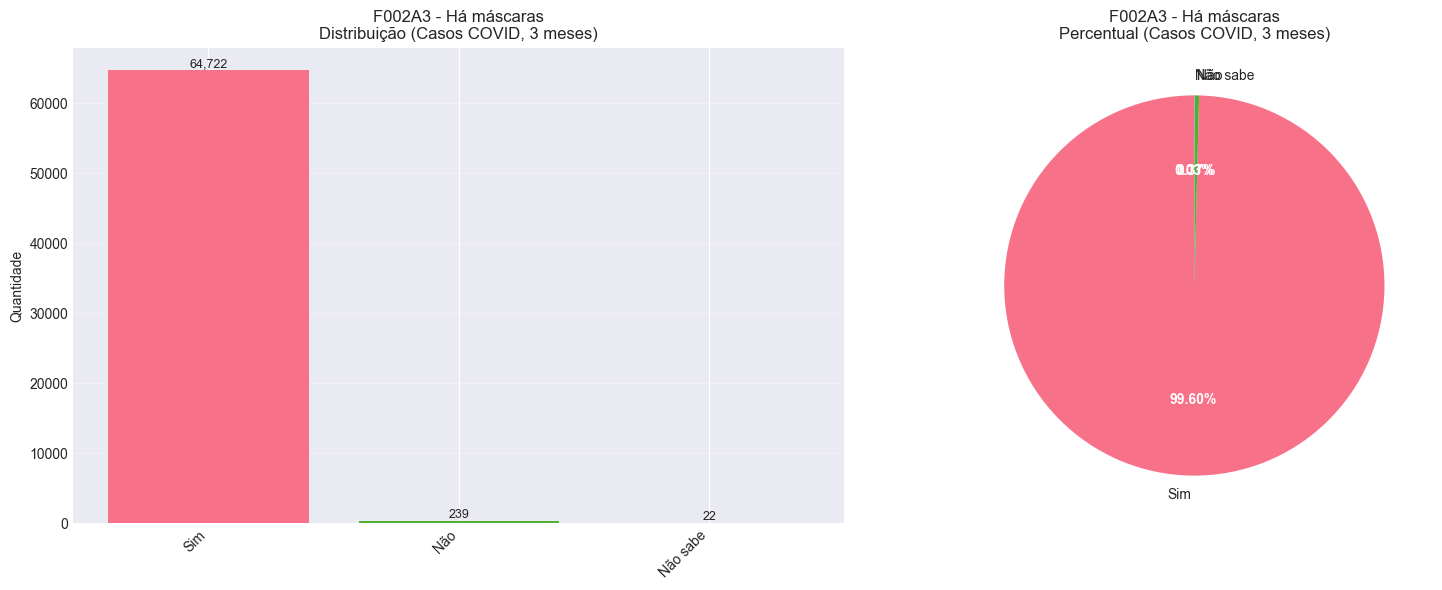

   Label  Quantidade  Percentual
     Sim       64722       99.60
     Não         239        0.37
Não sabe          22        0.03

################################################################################
Item 20/21: F002A4
################################################################################


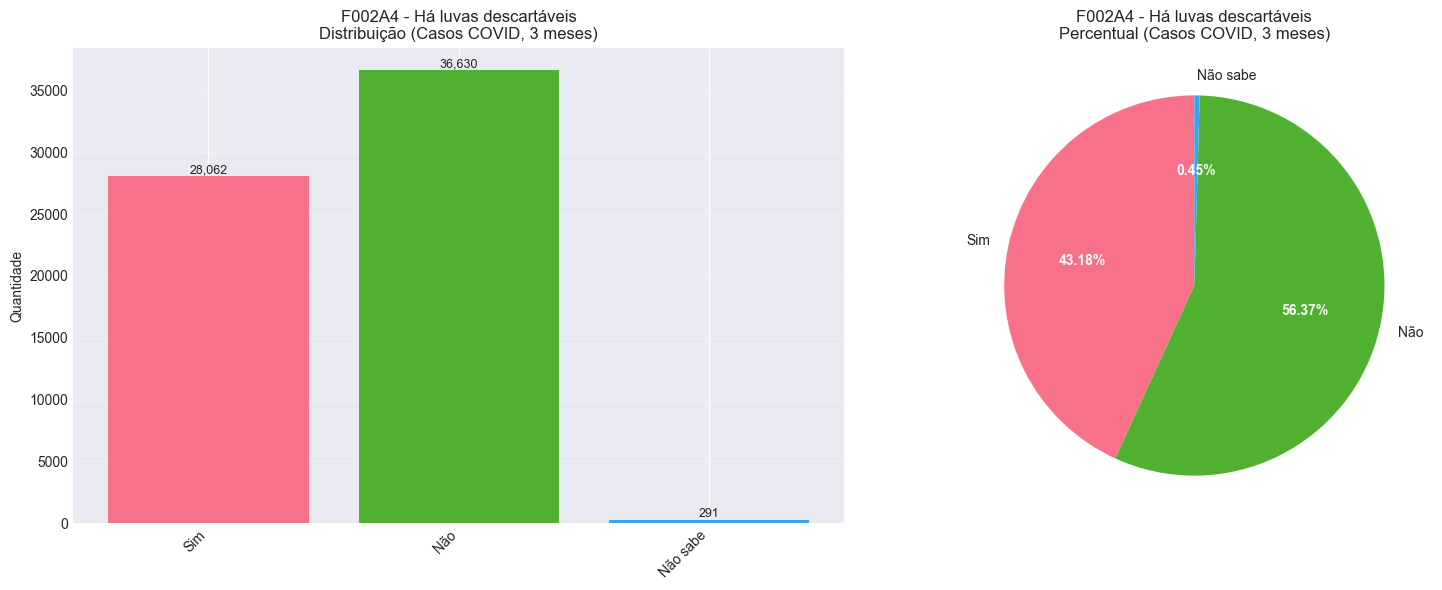

   Label  Quantidade  Percentual
     Sim       28062       43.18
     Não       36630       56.37
Não sabe         291        0.45

################################################################################
Item 21/21: F002A5
################################################################################


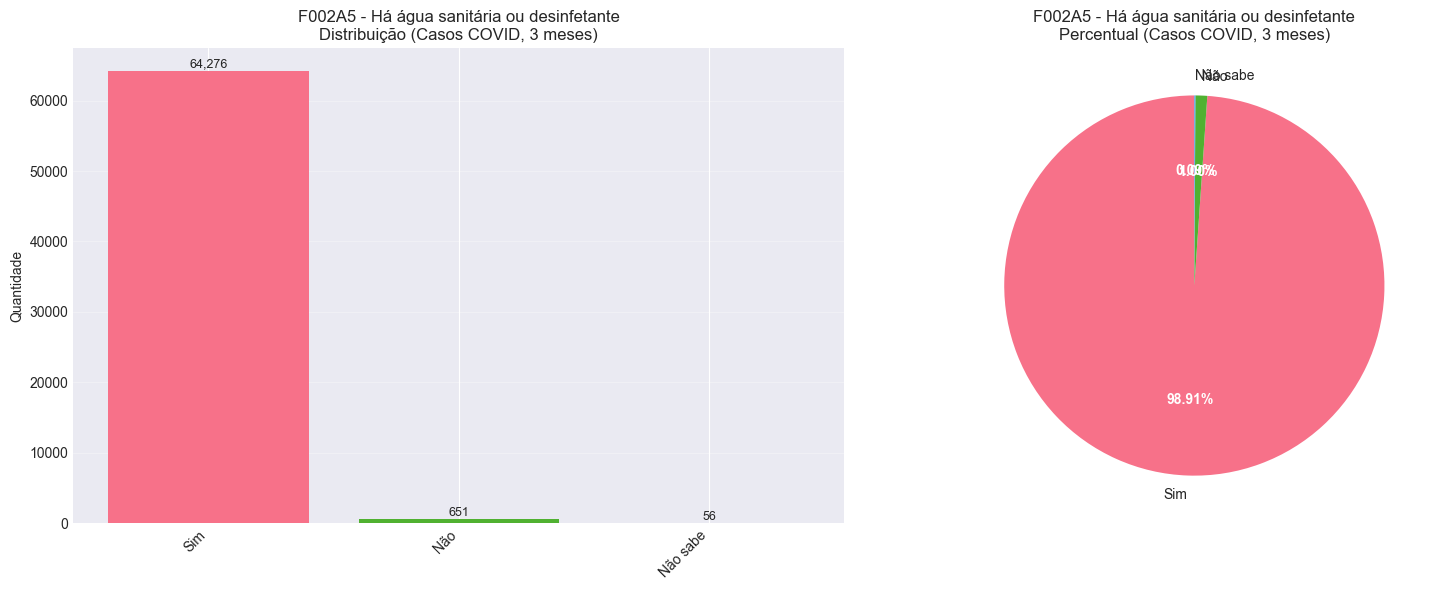

   Label  Quantidade  Percentual
     Sim       64276       98.91
     Não         651        1.00
Não sabe          56        0.09

✓ Análise concluída para casos COVID.

Nota: Sintomas (B0011-B00113), Atendimentos (B0041-B0046) e Comorbidades (B0101-B0106) estão nos gráficos comparativos da célula 9.


In [35]:
# Gerar gráficos para TODOS os itens selecionados, apenas casos COVID (3 meses)
# Filtrar apenas itens que têm dados disponíveis
# EXCLUIR itens que estão nos gráficos comparativos da célula 9

if df_transformado is not None and 'df_transformado_covid' in globals() and df_transformado_covid is not None:
    # Códigos que estão nos gráficos comparativos (célula 9) - não gerar gráficos individuais
    codigos_excluidos = [
        # Sintomas (B0011-B00113) - estão no gráfico comparativo de sintomas
        'B0011', 'B0012', 'B0013', 'B0014', 'B0015', 'B0016', 
        'B0017', 'B0018', 'B0019', 'B00110', 'B00111', 'B00112', 'B00113',
        # Atendimentos (B0041-B0046) - estão no gráfico comparativo de atendimentos
        'B0041', 'B0042', 'B0043', 'B0044', 'B0045', 'B0046',
        # Comorbidades (B0101-B0106) - estão no gráfico comparativo de comorbidades
        'B0101', 'B0102', 'B0103', 'B0104', 'B0105', 'B0106',
    ]
    
    # Primeiro, verificar quais itens têm dados E não estão excluídos
    itens_com_dados = {}
    for item_codigo, item_info in itens_analise.items():
        # Pular itens excluídos
        if item_codigo in codigos_excluidos:
            continue
            
        df_analise = preparar_dados_analise(df_transformado_covid, item_codigo, item_info)
        if df_analise is not None:
            # Para categóricas, verificar se há dados válidos (não apenas ignorados)
            if isinstance(df_analise, dict):
                # É numérico e tem dados
                itens_com_dados[item_codigo] = item_info
            elif len(df_analise) > 0:
                # É categórico, verificar se há dados além de "Ignorado"
                df_sem_ignorado = df_analise[df_analise['Codigo'] != 9]
                if len(df_sem_ignorado) > 0:
                    itens_com_dados[item_codigo] = item_info
    
    total_itens = len(itens_com_dados)
    print(f"Gerando gráficos para {total_itens} itens com dados disponíveis (apenas casos COVID, 3 meses)...\n")
    
    for idx, (item_codigo, item_info) in enumerate(itens_com_dados.items(), start=1):
        print(f"\n{'#'*80}")
        print(f"Item {idx}/{total_itens}: {item_codigo}")
        print(f"{'#'*80}")
        criar_grafico_item(df_transformado_covid, item_codigo, item_info)
    print("\n✓ Análise concluída para casos COVID.")
    print("\nNota: Sintomas (B0011-B00113), Atendimentos (B0041-B0046) e Comorbidades (B0101-B0106) estão nos gráficos comparativos da célula 9.")
else:
    print("Erro: df_transformado ou df_transformado_covid não está disponível.")


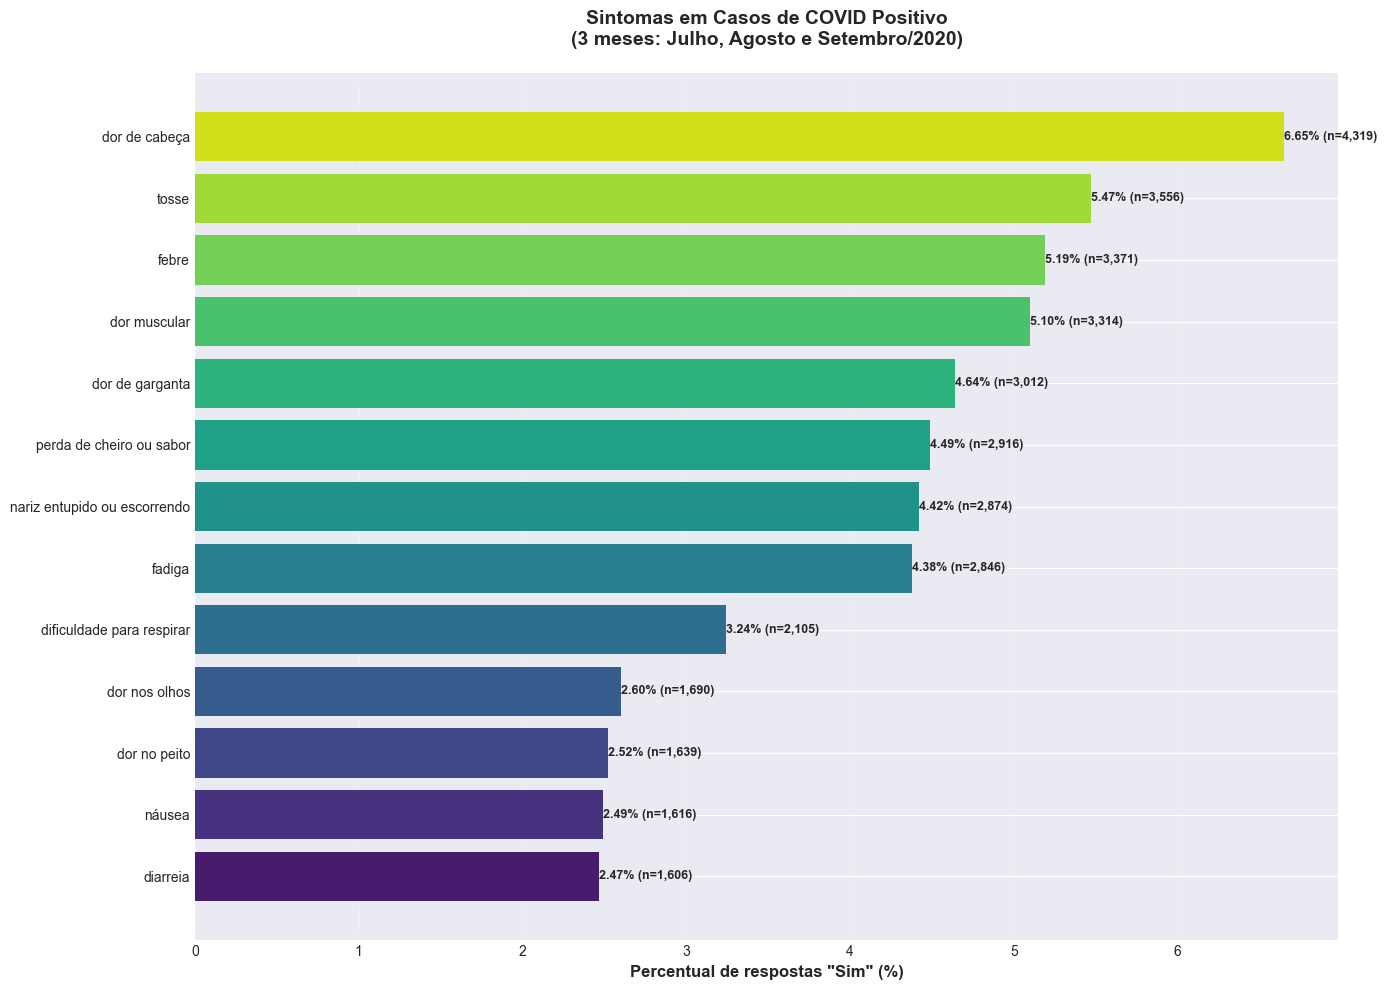


Tabela - Sintomas:
                        Nome  Percentual_Sim  Quantidade_Sim
                    diarreia            2.47            1606
                      náusea            2.49            1616
                dor no peito            2.52            1639
               dor nos olhos            2.60            1690
   dificuldade para respirar            3.24            2105
                      fadiga            4.38            2846
nariz entupido ou escorrendo            4.42            2874
    perda de cheiro ou sabor            4.49            2916
             dor de garganta            4.64            3012
                dor muscular            5.10            3314
                       febre            5.19            3371
                       tosse            5.47            3556
               dor de cabeça            6.65            4319


Análise de Atendimentos (Base: 11,739 pessoas)
Pessoas que buscaram atendimento PÚBLICO: 2,813 (23.96%)
Pessoas que buscaram

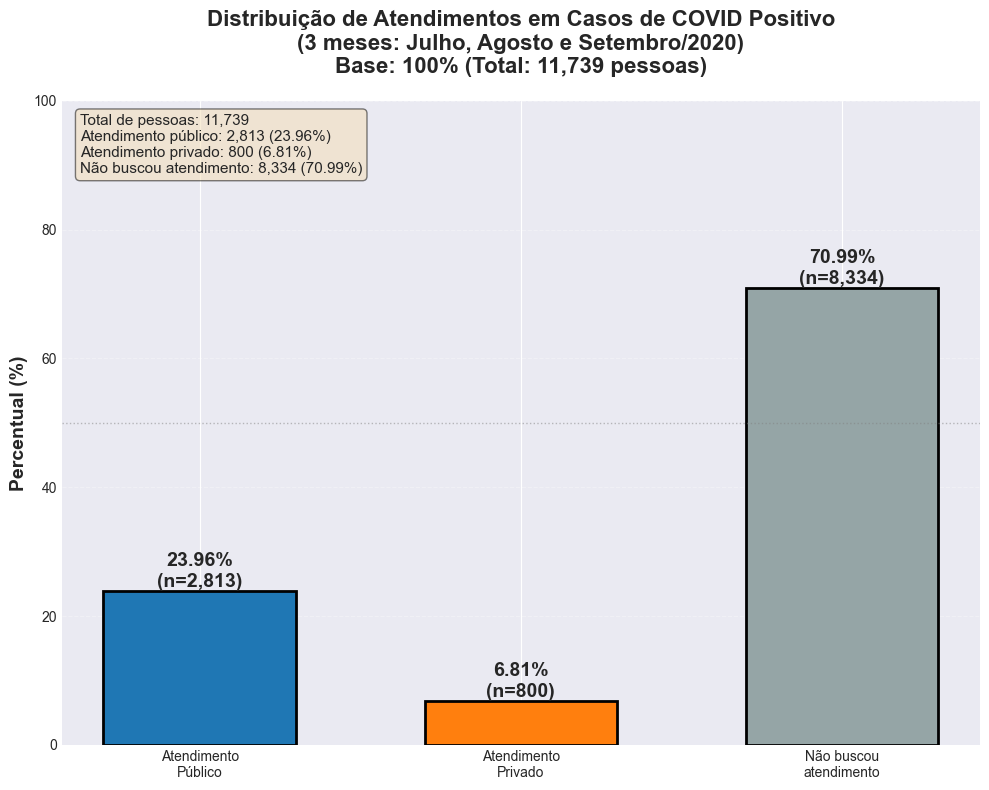

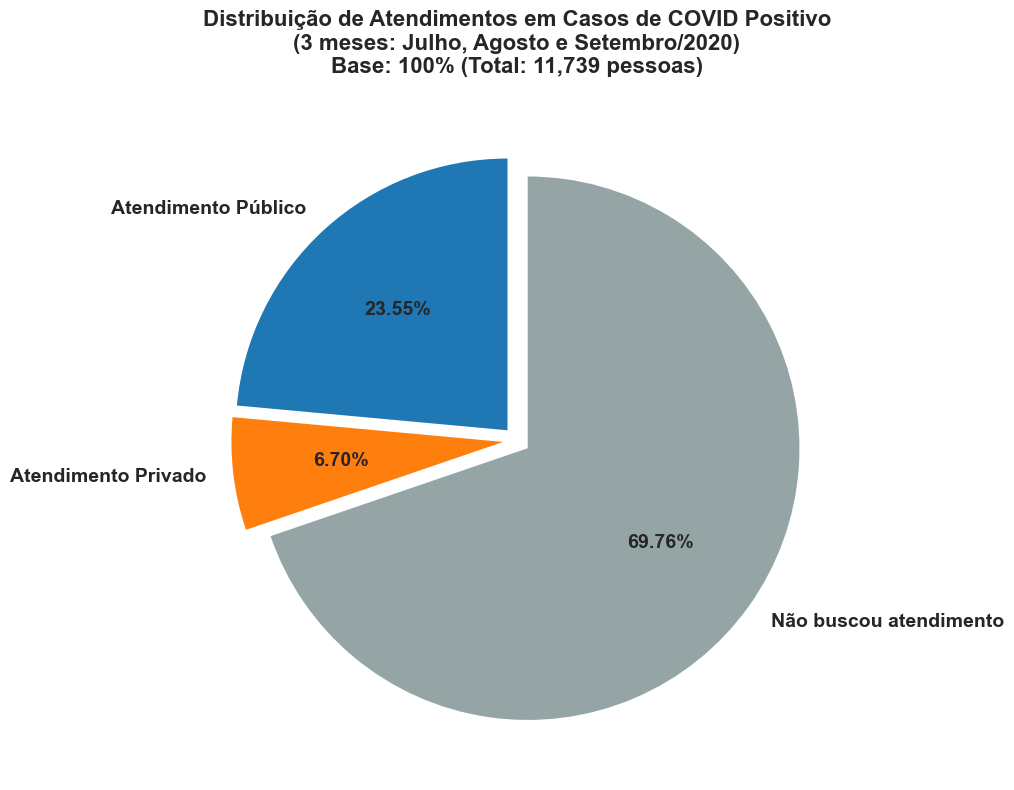

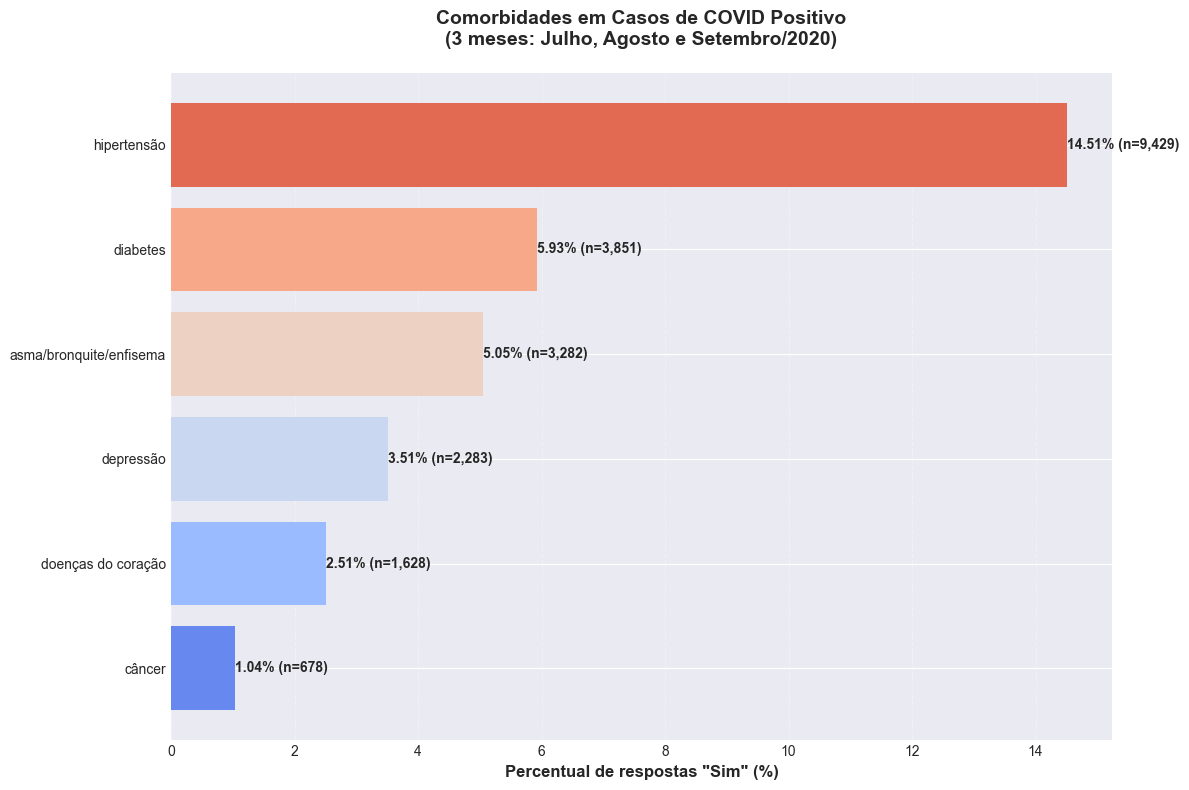

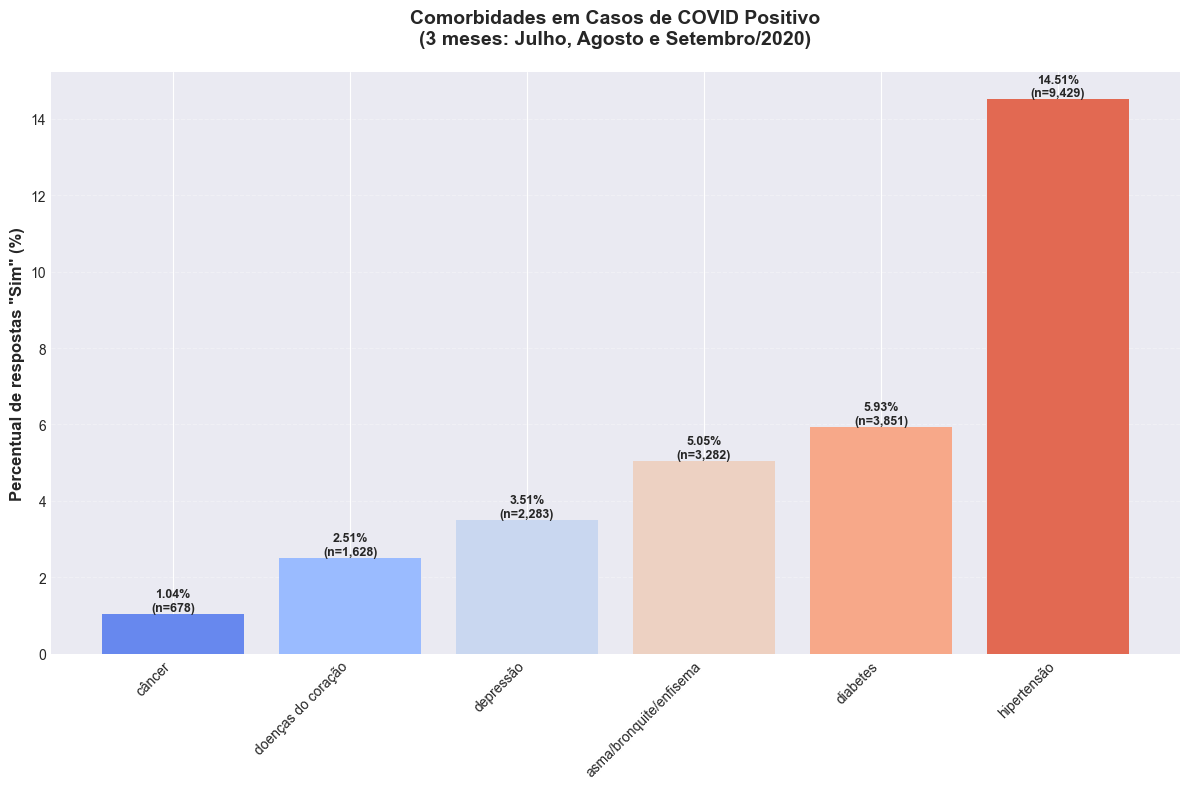


Tabela - Comorbidades:
                   Nome  Percentual_Sim  Quantidade_Sim
                 câncer            1.04             678
     doenças do coração            2.51            1628
              depressão            3.51            2283
asma/bronquite/enfisema            5.05            3282
               diabetes            5.93            3851
            hipertensão           14.51            9429


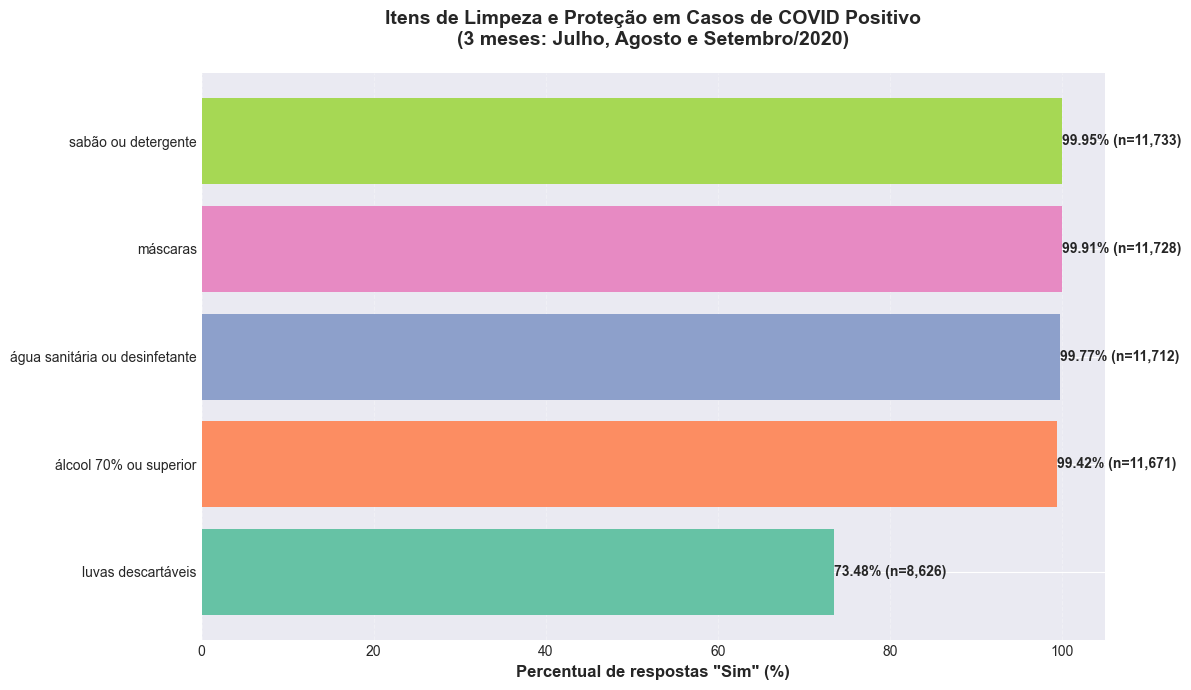


Tabela - Itens de Limpeza e Proteção:
                          Nome  Percentual_Sim  Quantidade_Sim
            luvas descartáveis           73.48            8626
        álcool 70% ou superior           99.42           11671
água sanitária ou desinfetante           99.77           11712
                      máscaras           99.91           11728
           sabão ou detergente           99.95           11733

✓ Gráficos comparativos concluídos!


In [36]:
# Gráficos comparativos: Sintomas, Atendimentos, Comorbidades e Itens de Limpeza

if 'df_transformado_covid' in globals() and df_transformado_covid is not None:
    # ===== GRÁFICO 1: Sintomas (B0011-B00113) - Barras horizontais =====
    sintomas_codigos = ['B0011', 'B0012', 'B0013', 'B0014', 'B0015', 'B0016', 
                        'B0017', 'B0018', 'B0019', 'B00110', 'B00111', 'B00112', 'B00113']
    
    sintomas_data = []
    
    for cod in sintomas_codigos:
        if cod in itens_analise:
            df_analise = preparar_dados_analise(df_transformado_covid, cod, itens_analise[cod])
            if df_analise is not None and not isinstance(df_analise, dict):
                # Buscar percentual de "Sim" (código 1)
                sim_row = df_analise[df_analise['Codigo'] == 1]
                if len(sim_row) > 0:
                    sintomas_data.append({
                        'Codigo': cod,
                        'Nome': itens_analise[cod]['nome'].replace('Na semana passada teve ', '').replace('?', ''),
                        'Percentual_Sim': sim_row.iloc[0]['Percentual'],
                        'Quantidade_Sim': sim_row.iloc[0]['Quantidade']
                    })
    
    if sintomas_data:
        df_sintomas = pd.DataFrame(sintomas_data).sort_values('Percentual_Sim', ascending=True)
        
        fig, ax = plt.subplots(figsize=(14, 10))
        cores = sns.color_palette('viridis', len(df_sintomas))
        bars = ax.barh(df_sintomas['Nome'], df_sintomas['Percentual_Sim'], color=cores)
        
        ax.set_xlabel('Percentual de respostas "Sim" (%)', fontsize=12, fontweight='bold')
        ax.set_title('Sintomas em Casos de COVID Positivo\n(3 meses: Julho, Agosto e Setembro/2020)', 
                     fontsize=14, fontweight='bold', pad=20)
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        
        # Adicionar valores nas barras
        for bar, pct, qtd in zip(bars, df_sintomas['Percentual_Sim'], df_sintomas['Quantidade_Sim']):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height() / 2.0, 
                   f'{pct:.2f}% (n={int(qtd):,})',
                   ha='left', va='center', fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("\nTabela - Sintomas:")
        print(df_sintomas[['Nome', 'Percentual_Sim', 'Quantidade_Sim']].to_string(index=False))
    
    # ===== GRÁFICO 2: Atendimentos Público vs Privado (base 100%) =====
    atendimentos_publico = ['B0041', 'B0042', 'B0043']  # posto/UBS, pronto socorro SUS, hospital SUS
    atendimentos_privado = ['B0044', 'B0045', 'B0046']  # ambulatório privado, pronto socorro privado, hospital privado
    
    # Usar id_cols SEM 'Mes' para contar pessoas únicas (não pessoa-mês)
    id_cols_pessoa = ['UF', 'CAPITAL', 'RM_RIDE', 'Estrato', 'UPA', 'posest']
    pessoas_unicas = df_transformado_covid[id_cols_pessoa].drop_duplicates()
    total_geral = len(pessoas_unicas)
    
    # Filtrar apenas linhas de atendimentos com Valor = 1 (Sim)
    df_atendimentos = df_transformado_covid[
        df_transformado_covid['Variavel'].isin(atendimentos_publico + atendimentos_privado) & 
        (df_transformado_covid['Valor'] == 1)
    ].copy()
    
    # Criar chave única para cada pessoa (sem mês)
    df_atendimentos['pessoa_id'] = df_atendimentos[id_cols_pessoa].apply(tuple, axis=1)
    
    # Agrupar por pessoa e verificar tipos de atendimento
    grupos = df_atendimentos.groupby('pessoa_id')['Variavel'].apply(set).reset_index()
    
    grupos['tem_publico'] = grupos['Variavel'].apply(
        lambda x: bool(x & set(atendimentos_publico))
    )
    grupos['tem_privado'] = grupos['Variavel'].apply(
        lambda x: bool(x & set(atendimentos_privado))
    )
    
    pessoas_com_publico = set(grupos[grupos['tem_publico']]['pessoa_id'].values)
    pessoas_com_privado = set(grupos[grupos['tem_privado']]['pessoa_id'].values)
    
    total_publico = len(pessoas_com_publico)
    total_privado = len(pessoas_com_privado)
    
    # Calcular pessoas que buscaram qualquer tipo de atendimento
    pessoas_com_atendimento = pessoas_com_publico | pessoas_com_privado
    total_com_atendimento = len(pessoas_com_atendimento)
    total_sem_atendimento = total_geral - total_com_atendimento
    
    # Calcular percentuais (base 100%)
    pct_publico = (total_publico / total_geral * 100) if total_geral > 0 else 0
    pct_privado = (total_privado / total_geral * 100) if total_geral > 0 else 0
    pct_sem_atendimento = (total_sem_atendimento / total_geral * 100) if total_geral > 0 else 0
    
    print(f"\n\n{'='*80}")
    print(f"Análise de Atendimentos (Base: {total_geral:,} pessoas)")
    print(f"{'='*80}")
    print(f"Pessoas que buscaram atendimento PÚBLICO: {total_publico:,} ({pct_publico:.2f}%)")
    print(f"Pessoas que buscaram atendimento PRIVADO: {total_privado:,} ({pct_privado:.2f}%)")
    print(f"Pessoas que NÃO buscaram atendimento: {total_sem_atendimento:,} ({pct_sem_atendimento:.2f}%)")
    
    # Criar gráfico de barras com as 3 categorias (base 100% = total_geral)
    fig, ax = plt.subplots(figsize=(10, 8))
    
    categorias = ['Atendimento\nPúblico', 'Atendimento\nPrivado', 'Não buscou\natendimento']
    valores = [pct_publico, pct_privado, pct_sem_atendimento]
    cores = ['#1f77b4', '#ff7f0e', '#95a5a6']  # Azul para público, laranja para privado, cinza para não buscou
    
    bars = ax.bar(categorias, valores, color=cores, width=0.6, edgecolor='black', linewidth=2)
    
    # Adicionar valores nas barras
    for bar, valor, qtd in zip(bars, valores, [total_publico, total_privado, total_sem_atendimento]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height,
                f'{valor:.2f}%\n(n={qtd:,})', ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    ax.set_ylabel('Percentual (%)', fontsize=14, fontweight='bold')
    ax.set_title('Distribuição de Atendimentos em Casos de COVID Positivo\n(3 meses: Julho, Agosto e Setembro/2020)\nBase: 100% (Total: 11,739 pessoas)', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Adicionar linha de referência em 50%
    ax.axhline(y=50, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    
    # Adicionar informações adicionais
    info_text = f"""Total de pessoas: {total_geral:,}
Atendimento público: {total_publico:,} ({pct_publico:.2f}%)
Atendimento privado: {total_privado:,} ({pct_privado:.2f}%)
Não buscou atendimento: {total_sem_atendimento:,} ({pct_sem_atendimento:.2f}%)"""
    
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # Gráfico de pizza com as 3 categorias
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sizes = [pct_publico, pct_privado, pct_sem_atendimento]
    labels = ['Atendimento Público', 'Atendimento Privado', 'Não buscou atendimento']
    cores_pizza = ['#1f77b4', '#ff7f0e', '#95a5a6']  # Azul, laranja, cinza
    explode = (0.05, 0.05, 0.05)
    
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.2f%%',
                                      colors=cores_pizza, explode=explode,
                                      startangle=90, textprops={'fontsize': 14, 'fontweight': 'bold'})
    
    ax.set_title('Distribuição de Atendimentos em Casos de COVID Positivo\n(3 meses: Julho, Agosto e Setembro/2020)\nBase: 100% (Total: 11,739 pessoas)',
                 fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # ===== GRÁFICO 3: Comorbidades (B0101-B0106) - Barras horizontais =====
    comorbidades_codigos = ['B0101', 'B0102', 'B0103', 'B0104', 'B0105', 'B0106']
    
    comorbidades_data = []
    
    for cod in comorbidades_codigos:
        if cod in itens_analise:
            df_analise = preparar_dados_analise(df_transformado_covid, cod, itens_analise[cod])
            if df_analise is not None and not isinstance(df_analise, dict):
                # Buscar percentual de "Sim" (código 1)
                sim_row = df_analise[df_analise['Codigo'] == 1]
                if len(sim_row) > 0:
                    comorbidades_data.append({
                        'Codigo': cod,
                        'Nome': itens_analise[cod]['nome'].replace('Diagnóstico de ', ''),
                        'Percentual_Sim': sim_row.iloc[0]['Percentual'],
                        'Quantidade_Sim': sim_row.iloc[0]['Quantidade']
                    })
    
    if comorbidades_data:
        df_comorbidades = pd.DataFrame(comorbidades_data).sort_values('Percentual_Sim', ascending=True)
        
        # Gráfico de barras horizontais
        fig, ax = plt.subplots(figsize=(12, 8))
        cores = sns.color_palette('coolwarm', len(df_comorbidades))
        bars = ax.barh(df_comorbidades['Nome'], df_comorbidades['Percentual_Sim'], color=cores)
        
        ax.set_xlabel('Percentual de respostas "Sim" (%)', fontsize=12, fontweight='bold')
        ax.set_title('Comorbidades em Casos de COVID Positivo\n(3 meses: Julho, Agosto e Setembro/2020)', 
                     fontsize=14, fontweight='bold', pad=20)
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        
        # Adicionar valores nas barras
        for bar, pct, qtd in zip(bars, df_comorbidades['Percentual_Sim'], df_comorbidades['Quantidade_Sim']):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height() / 2.0, 
                   f'{pct:.2f}% (n={int(qtd):,})',
                   ha='left', va='center', fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Gráfico de barras verticais (alternativa)
        fig, ax = plt.subplots(figsize=(12, 8))
        bars = ax.bar(df_comorbidades['Nome'], df_comorbidades['Percentual_Sim'], color=cores)
        
        ax.set_ylabel('Percentual de respostas "Sim" (%)', fontsize=12, fontweight='bold')
        ax.set_title('Comorbidades em Casos de COVID Positivo\n(3 meses: Julho, Agosto e Setembro/2020)', 
                     fontsize=14, fontweight='bold', pad=20)
        ax.set_xticklabels(df_comorbidades['Nome'], rotation=45, ha='right')
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Adicionar valores nas barras
        for bar, pct, qtd in zip(bars, df_comorbidades['Percentual_Sim'], df_comorbidades['Quantidade_Sim']):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2.0, height,
                   f'{pct:.2f}%\n(n={int(qtd):,})',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("\nTabela - Comorbidades:")
        print(df_comorbidades[['Nome', 'Percentual_Sim', 'Quantidade_Sim']].to_string(index=False))
    
    # ===== GRÁFICO 4: Itens de Limpeza e Proteção (F002A1-F002A5) =====
    limpeza_codigos = ['F002A1', 'F002A2', 'F002A3', 'F002A4', 'F002A5']
    
    limpeza_data = []
    
    # Usar id_cols SEM 'Mes' para contar pessoas únicas (não pessoa-mês)
    id_cols_pessoa = ['UF', 'CAPITAL', 'RM_RIDE', 'Estrato', 'UPA', 'posest']
    
    for cod in limpeza_codigos:
        if cod in itens_analise:
            # Filtrar apenas linhas desta variável específica
            df_item = df_transformado_covid[df_transformado_covid['Variavel'] == cod].copy()
            df_item = df_item[df_item['Valor'].notna()].copy()
            
            if len(df_item) > 0:
                # Criar chave única para cada pessoa (sem mês)
                df_item['pessoa_id'] = df_item[id_cols_pessoa].apply(tuple, axis=1)
                
                # Contar pessoas únicas que responderam (total)
                pessoas_unicas_total = set(df_item['pessoa_id'].unique())
                total_pessoas = len(pessoas_unicas_total)
                
                # Contar pessoas únicas que responderam "Sim" (Valor = 1)
                df_item_sim = df_item[df_item['Valor'] == 1].copy()
                pessoas_unicas_sim = set(df_item_sim['pessoa_id'].unique())
                qtd_sim = len(pessoas_unicas_sim)
                
                # Calcular percentual baseado em pessoas únicas
                pct_sim = (qtd_sim / total_pessoas * 100) if total_pessoas > 0 else 0
                
                limpeza_data.append({
                    'Codigo': cod,
                    'Nome': itens_analise[cod]['nome'].replace('Há ', '').replace(' no domicílio', ''),
                    'Percentual_Sim': round(pct_sim, 2),
                    'Quantidade_Sim': qtd_sim
                })
    
    if limpeza_data:
        df_limpeza = pd.DataFrame(limpeza_data).sort_values('Percentual_Sim', ascending=True)
        
        # Gráfico 1: Barras horizontais com todos os itens
        fig, ax = plt.subplots(figsize=(12, 7))
        cores = sns.color_palette('Set2', len(df_limpeza))
        bars = ax.barh(df_limpeza['Nome'], df_limpeza['Percentual_Sim'], color=cores)
        
        ax.set_xlabel('Percentual de respostas "Sim" (%)', fontsize=12, fontweight='bold')
        ax.set_title('Itens de Limpeza e Proteção em Casos de COVID Positivo\n(3 meses: Julho, Agosto e Setembro/2020)', 
                     fontsize=14, fontweight='bold', pad=20)
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        
        # Adicionar valores nas barras
        for bar, pct, qtd in zip(bars, df_limpeza['Percentual_Sim'], df_limpeza['Quantidade_Sim']):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height() / 2.0, 
                   f'{pct:.2f}% (n={int(qtd):,})',
                   ha='left', va='center', fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("\nTabela - Itens de Limpeza e Proteção:")
        print(df_limpeza[['Nome', 'Percentual_Sim', 'Quantidade_Sim']].to_string(index=False))
        
        id_cols_pessoa = ['UF', 'CAPITAL', 'RM_RIDE', 'Estrato', 'UPA', 'posest']
        
        # Total de pessoas com COVID (base para cálculo de percentuais)
        pessoas_covid_unicas = df_transformado_covid[id_cols_pessoa].drop_duplicates()
        pessoas_covid_ids = set(pessoas_covid_unicas[id_cols_pessoa].apply(tuple, axis=1).values)
        total_geral = len(pessoas_covid_ids)
        
        # Filtrar TODAS as linhas de itens de limpeza (não apenas Valor=1) para identificar quem respondeu
        df_limpeza_todas = df_transformado_covid[
            df_transformado_covid['Variavel'].isin(limpeza_codigos)
        ].copy()
        
        # Criar chave única para cada pessoa (sem mês)
        df_limpeza_todas['pessoa_id'] = df_limpeza_todas[id_cols_pessoa].apply(tuple, axis=1)
        
        # Filtrar apenas linhas de itens de limpeza com Valor = 1 (Sim)
        df_limpeza_items = df_limpeza_todas[df_limpeza_todas['Valor'] == 1].copy()
        
        # Agrupar por pessoa e verificar quantos itens cada uma possui (em qualquer mês)
        if len(df_limpeza_items) > 0:
            grupos_limpeza = df_limpeza_items.groupby('pessoa_id')['Variavel'].apply(set).reset_index()
            grupos_limpeza['qtd_itens'] = grupos_limpeza['Variavel'].apply(len)
            
            # Pessoas que possuem pelo menos 1 item (em qualquer mês)
            pessoas_com_itens = set(grupos_limpeza[grupos_limpeza['qtd_itens'] > 0]['pessoa_id'].values)
        else:
            pessoas_com_itens = set()
        
        # Pessoas que não possuem nenhum item = todas as pessoas com COVID menos as que têm itens
        pessoas_sem_itens = pessoas_covid_ids - pessoas_com_itens
        
        total_com_itens = len(pessoas_com_itens)
        total_sem_itens = len(pessoas_sem_itens)
        

    
    print("\n✓ Gráficos comparativos concluídos!")
else:
    print('Erro: df_transformado_covid não está disponível.')
